# Multivariate Time Series Forecast Using Bidirectional Stacked LSTM
### multivariate time series–time series which has more than one time-dependent variable.

![image.png](https://miro.medium.com/v2/resize:fit:720/format:webp/1*WrKW5zBbrRmRUbmSL67GMQ.png)


image from https://vannguyen-8073.medium.com/using-lstm-multivariate-and-univariate-in-order-to-predict-stock-market-39e8f6551c93

#### What is Multivariate Forecasting ?*
    If the model predicts dependent variable (y) based on one independent variable (x), it is called univariate forecasting. For Multivariate forecasting, it simply means predicting dependent variable (y) based on more than one independent variable (x).

#### What is Multi-step Forecasting ?*
    If the model predicts a single value for next time-step, it is called one-step forecast. For Multi-step forecast, it means predicting few times-steps ahead.

*from [Multi-Step Multivariate Time-Series Forecasting using LSTM](https://pangkh98.medium.com/multi-step-multivariate-time-series-forecasting-using-lstm-92c6d22cd9c2)

### Further reading:

#### [Hands-on TensorFlow Multivariate Time Series Sequence to Sequence Predictions with LSTM](https://medium.com/@canerkilinc/hands-on-multivariate-time-series-sequence-to-sequence-predictions-with-lstm-tensorflow-keras-ce86f2c0e4fa)

#### [Long Short-Term Memory (LSTM) networks Magic](https://medium.com/pythons-gurus/long-short-term-memory-lstm-networks-magic-88552c886cff)

#### [Sequence Prediction with Bidirectional LSTM Model](https://medium.com/@nutanbhogendrasharma/sequence-prediction-with-bidirectional-lstm-model-fc8b94b3357)

#### [Multivariate Multi-step Time Series Forecasting using Stacked LSTM sequence to sequence Autoencoder in Tensorflow 2.0 / Keras](https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/)

#### [CNN-LSTM-Based Models for Multiple Parallel Input and Multi-Step Forecast](https://towardsdatascience.com/cnn-lstm-based-models-for-multiple-parallel-input-and-multi-step-forecast-6fe2172f7668)


In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd

#Plotting and Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

#from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from statsmodels.tsa.stattools import acf, pacf, q_stat, adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.api import VAR

from scipy.stats import probplot, moment
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, InputLayer, TimeDistributed, RepeatVector

In [3]:
import platform
print(f"Python version: {platform.python_version()}")
print(f"numpy version: {np.__version__}")
print(f"panda version: {pd.__version__}")
print(f"seaborn version: {sns.__version__}")
import matplotlib
print(f"matplotlib version: {matplotlib.__version__}")
import sklearn 
print(f"sklearn version: {sklearn. __version__}")
import statsmodels
print(f"statsmodel version: {statsmodels.__version__}")
import scipy
print(f"scipy version: {scipy.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print("Cuda Available: ", tf.test.is_built_with_cuda())

# https://www.xda-developers.com/use-gpu-jupyter-notebook/

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)
else:
    print("Failed to detect a GPU.")

Python version: 3.10.14
numpy version: 1.26.4
panda version: 2.2.1
seaborn version: 0.13.2
matplotlib version: 3.7.5
sklearn version: 1.4.1.post1
statsmodel version: 0.14.1
scipy version: 1.14.1
TensorFlow version: 2.10.0
Cuda Available:  True
Found a GPU with the name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
'''
from tensorflow.keras import backend as K

# Reset the session and clear memory
K.clear_session()

'''

'\nfrom tensorflow.keras import backend as K\n\n# Reset the session and clear memory\nK.clear_session()\n\n'

In [5]:
# Define a Function to Format the Time: This function will convert the elapsed time into hours, minutes, and seconds.
def format_time(seconds):
    hours, rem = divmod(seconds, 3600)
    minutes, seconds = divmod(rem, 60)
    return f"{int(hours)}h {int(minutes)}m {seconds:.2f}s"

In [6]:
# dataset from https://archive.ics.uci.edu/dataset/374/appliances+energy+prediction
df =  pd.read_csv('energydata_complete.csv', delimiter=',')

In [7]:
df.head()

date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2  2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3  2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
4  2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9     T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53  6.600000        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56  6.483333        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50  6.366667        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40  6.250000        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40  6.133333        733.9   

   RH_out  Windspeed  Visibility  Tdewpoint        rv1        rv2  
0    92.0   7.000000   63.000000        5.3  13.275433  13.275433  
1    92.0   6.666667   59.166667        5.2  18.606195  18.606195  
2    92.0   6.333333   55.333333        5.1  28.642668  28.642668  
3    92.0   6.000000   51.500000        5.0  45.410389  45.410389  
4    92.0   5.666667   47.666667        4.9  10.084097  10.084097  

[5 rows x 29 columns]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

#### Attribute Information: The energy data was logged every 10 minutes for about 4.5 months

    date time year-month-day hour:minute:second 
    Appliances, energy use in Wh
    lights, energy use of light fixtures in the house in Wh
    T1, Temperature in kitchen area, in Celsius
    RH_1, Humidity in kitchen area, in %
    T2, Temperature in living room area, in Celsius
    RH_2, Humidity in living room area, in %
    T3, Temperature in laundry room area
    RH_3, Humidity in laundry room area, in %
    T4, Temperature in office room, in Celsius
    RH_4, Humidity in office room, in %
    T5, Temperature in bathroom, in Celsius
    RH_5, Humidity in bathroom, in %
    T6, Temperature outside the building (north side), in Celsius
    RH_6, Humidity outside the building (north side), in %
    T7, Temperature in ironing room , in Celsius
    RH_7, Humidity in ironing room, in %
    T8, Temperature in teenager room 2, in Celsius
    RH_8, Humidity in teenager room 2, in %
    T9, Temperature in parents room, in Celsius
    RH_9, Humidity in parents room, in %
    T_out, Temperature outside (from Chievres weather station), in Celsius
    Pressure (from Chievres weather station), in mm Hg
    RH_out, Humidity outside (from Chievres weather station), in %
    Wind speed (from Chievres weather station), in m/s
    Visibility (from Chievres weather station), in km
    Tdewpoint (from Chievres weather station), Â°C
    rv1, Random variable 1, nondimensional
    rv2, Random variable 2, nondimensional

In [9]:
df.isna().sum(axis=0) # check any NA same as df.isnull().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

In [10]:
df['date'] = pd.to_datetime(df['date'], format='mixed')  # change type to datetime

In [11]:
df['date']

0       2016-01-11 17:00:00
1       2016-01-11 17:10:00
2       2016-01-11 17:20:00
3       2016-01-11 17:30:00
4       2016-01-11 17:40:00
                ...        
19730   2016-05-27 17:20:00
19731   2016-05-27 17:30:00
19732   2016-05-27 17:40:00
19733   2016-05-27 17:50:00
19734   2016-05-27 18:00:00
Name: date, Length: 19735, dtype: datetime64[ns]

#### For simplicity, considers only eight of the original columns

In [12]:
sub_df = df.set_index('date')[['Appliances', 'lights','T_out', 'RH_out', 'Press_mm_hg', 'Windspeed', 'Visibility', 'Tdewpoint']]

In [13]:
sub_df.tail()

Appliances  lights      T_out     RH_out  Press_mm_hg  \
date                                                                         
2016-05-27 17:20:00         100       0  22.733333  55.666667        755.2   
2016-05-27 17:30:00          90       0  22.600000  56.000000        755.2   
2016-05-27 17:40:00         270      10  22.466667  56.333333        755.2   
2016-05-27 17:50:00         420      10  22.333333  56.666667        755.2   
2016-05-27 18:00:00         430      10  22.200000  57.000000        755.2   

                     Windspeed  Visibility  Tdewpoint  
date                                                   
2016-05-27 17:20:00   3.333333   23.666667  13.333333  
2016-05-27 17:30:00   3.500000   24.500000  13.300000  
2016-05-27 17:40:00   3.666667   25.333333  13.266667  
2016-05-27 17:50:00   3.833333   26.166667  13.233333  
2016-05-27 18:00:00   4.000000   27.000000  13.200000

### Exploratory Data Analysis

In [170]:
sub_df.describe()

Appliances        lights         T_out        RH_out   Press_mm_hg  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      97.694958      3.801875      7.411665     79.750418    755.522602   
std      102.524891      7.935988      5.317409     14.901088      7.399441   
min       10.000000      0.000000     -5.000000     24.000000    729.300000   
25%       50.000000      0.000000      3.666667     70.333333    750.933333   
50%       60.000000      0.000000      6.916667     83.666667    756.100000   
75%      100.000000      0.000000     10.408333     91.666667    760.933333   
max     1080.000000     70.000000     26.100000    100.000000    772.300000   

          Windspeed    Visibility     Tdewpoint  
count  19735.000000  19735.000000  19735.000000  
mean       4.039752     38.330834      3.760707  
std        2.451221     11.794719      4.194648  
min        0.000000      1.000000     -6.600000  
25%        2.000000     29.000000      0.900000  
50%        3.666667     40.000000      3.433333  
75%        5.500000     40.000000      6.566667  
max       14.000000     66.000000     15.500000

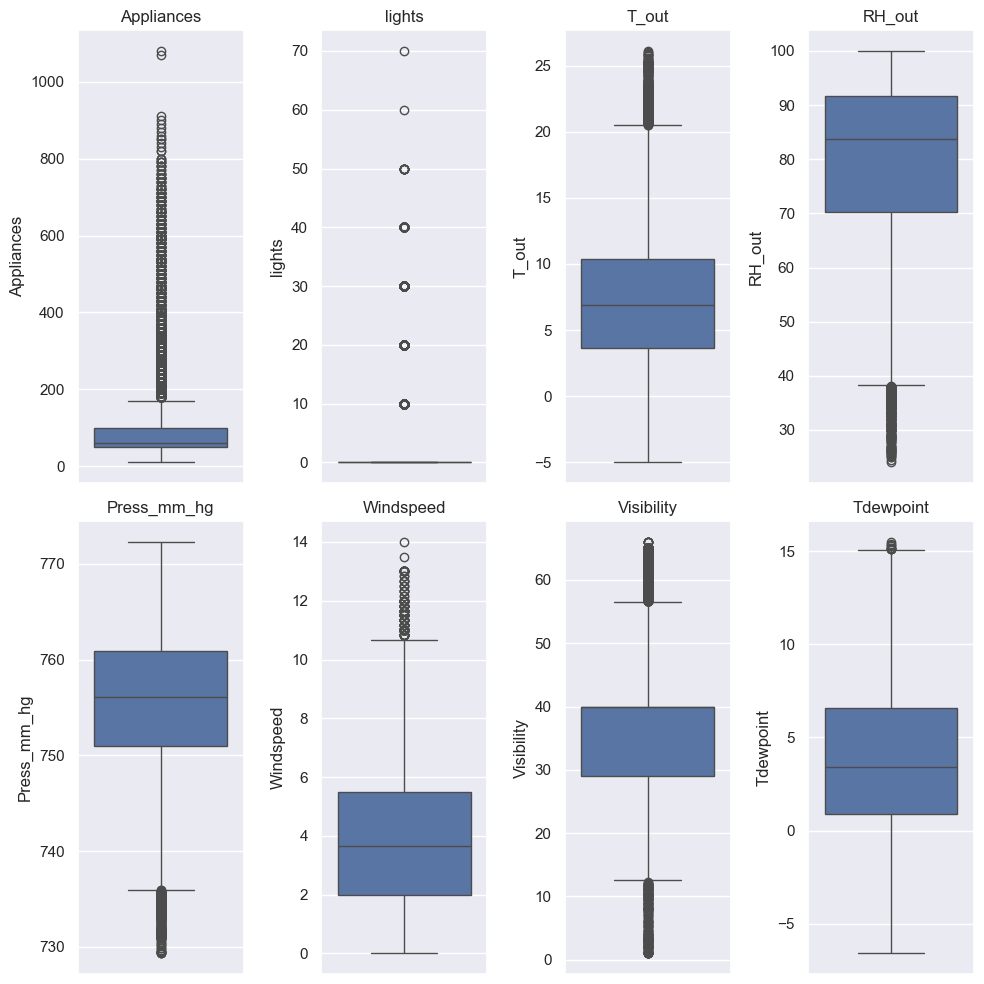

In [171]:
# Create a 2x4 grid of boxplots
fig, axes = plt.subplots(2, 4, figsize=(10, 10))

n_rows = 2
n_cols = 4
col_num = 0

for i in range(n_rows):
    for j in range(n_cols):
        sns.boxplot(ax=axes[i, j], data=sub_df.iloc[:, col_num])
        axes[i, j].set_title(sub_df.columns[col_num])
        col_num += 1

plt.tight_layout()
plt.show()

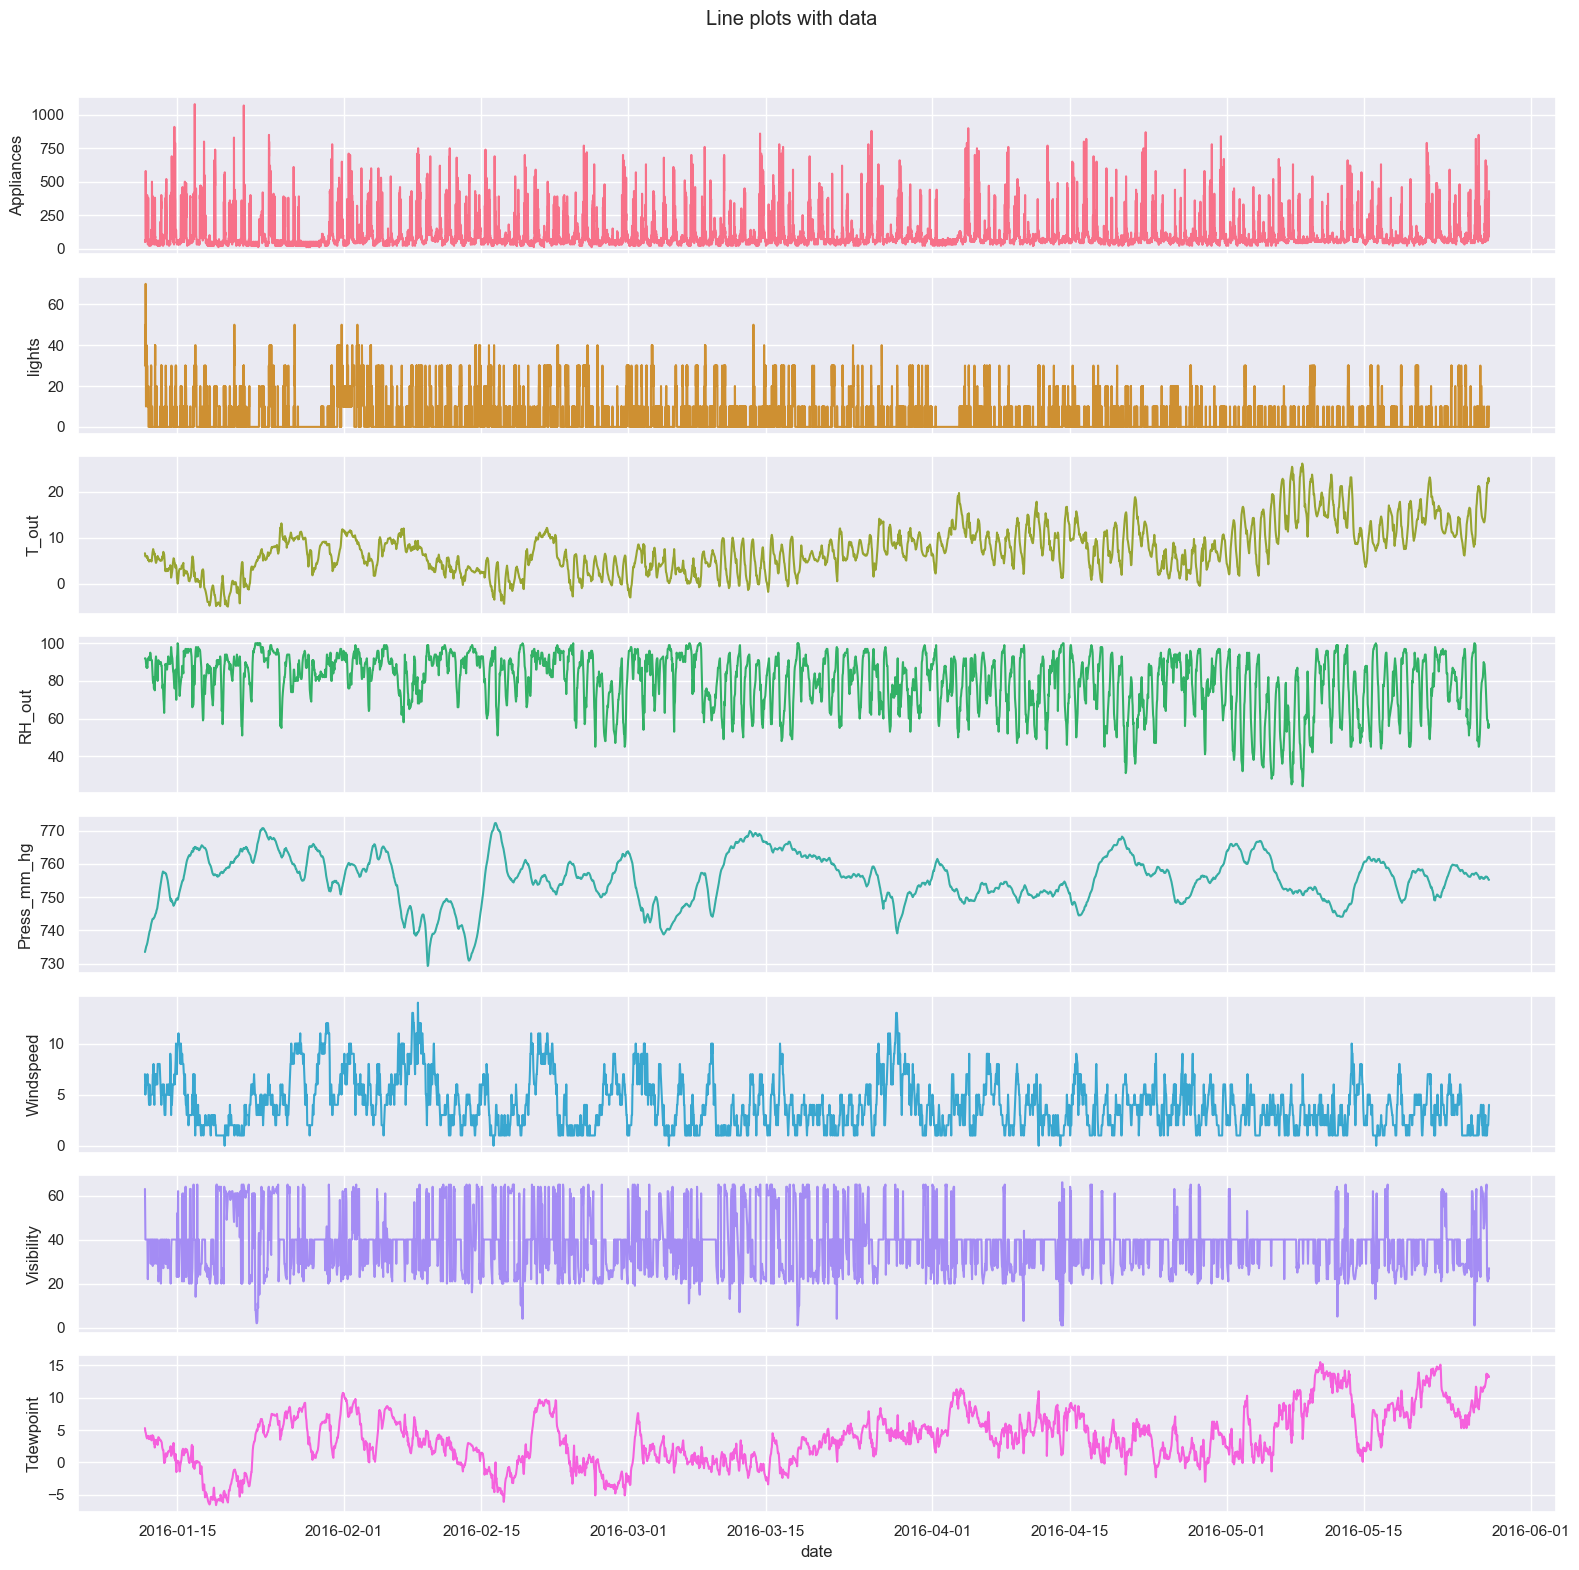

In [172]:
# Create subplots
fig, axes = plt.subplots(8,1, figsize=(16, 16) , sharex=True)
# Set the main title 
fig.suptitle('Line plots with data')

# Define a color palette
palette = sns.color_palette("husl", 8)

# Create line plots
for i, col in enumerate(list(sub_df.columns)):
    sns.lineplot(ax=axes[i], data=sub_df, x='date', y=col, color=palette[i])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

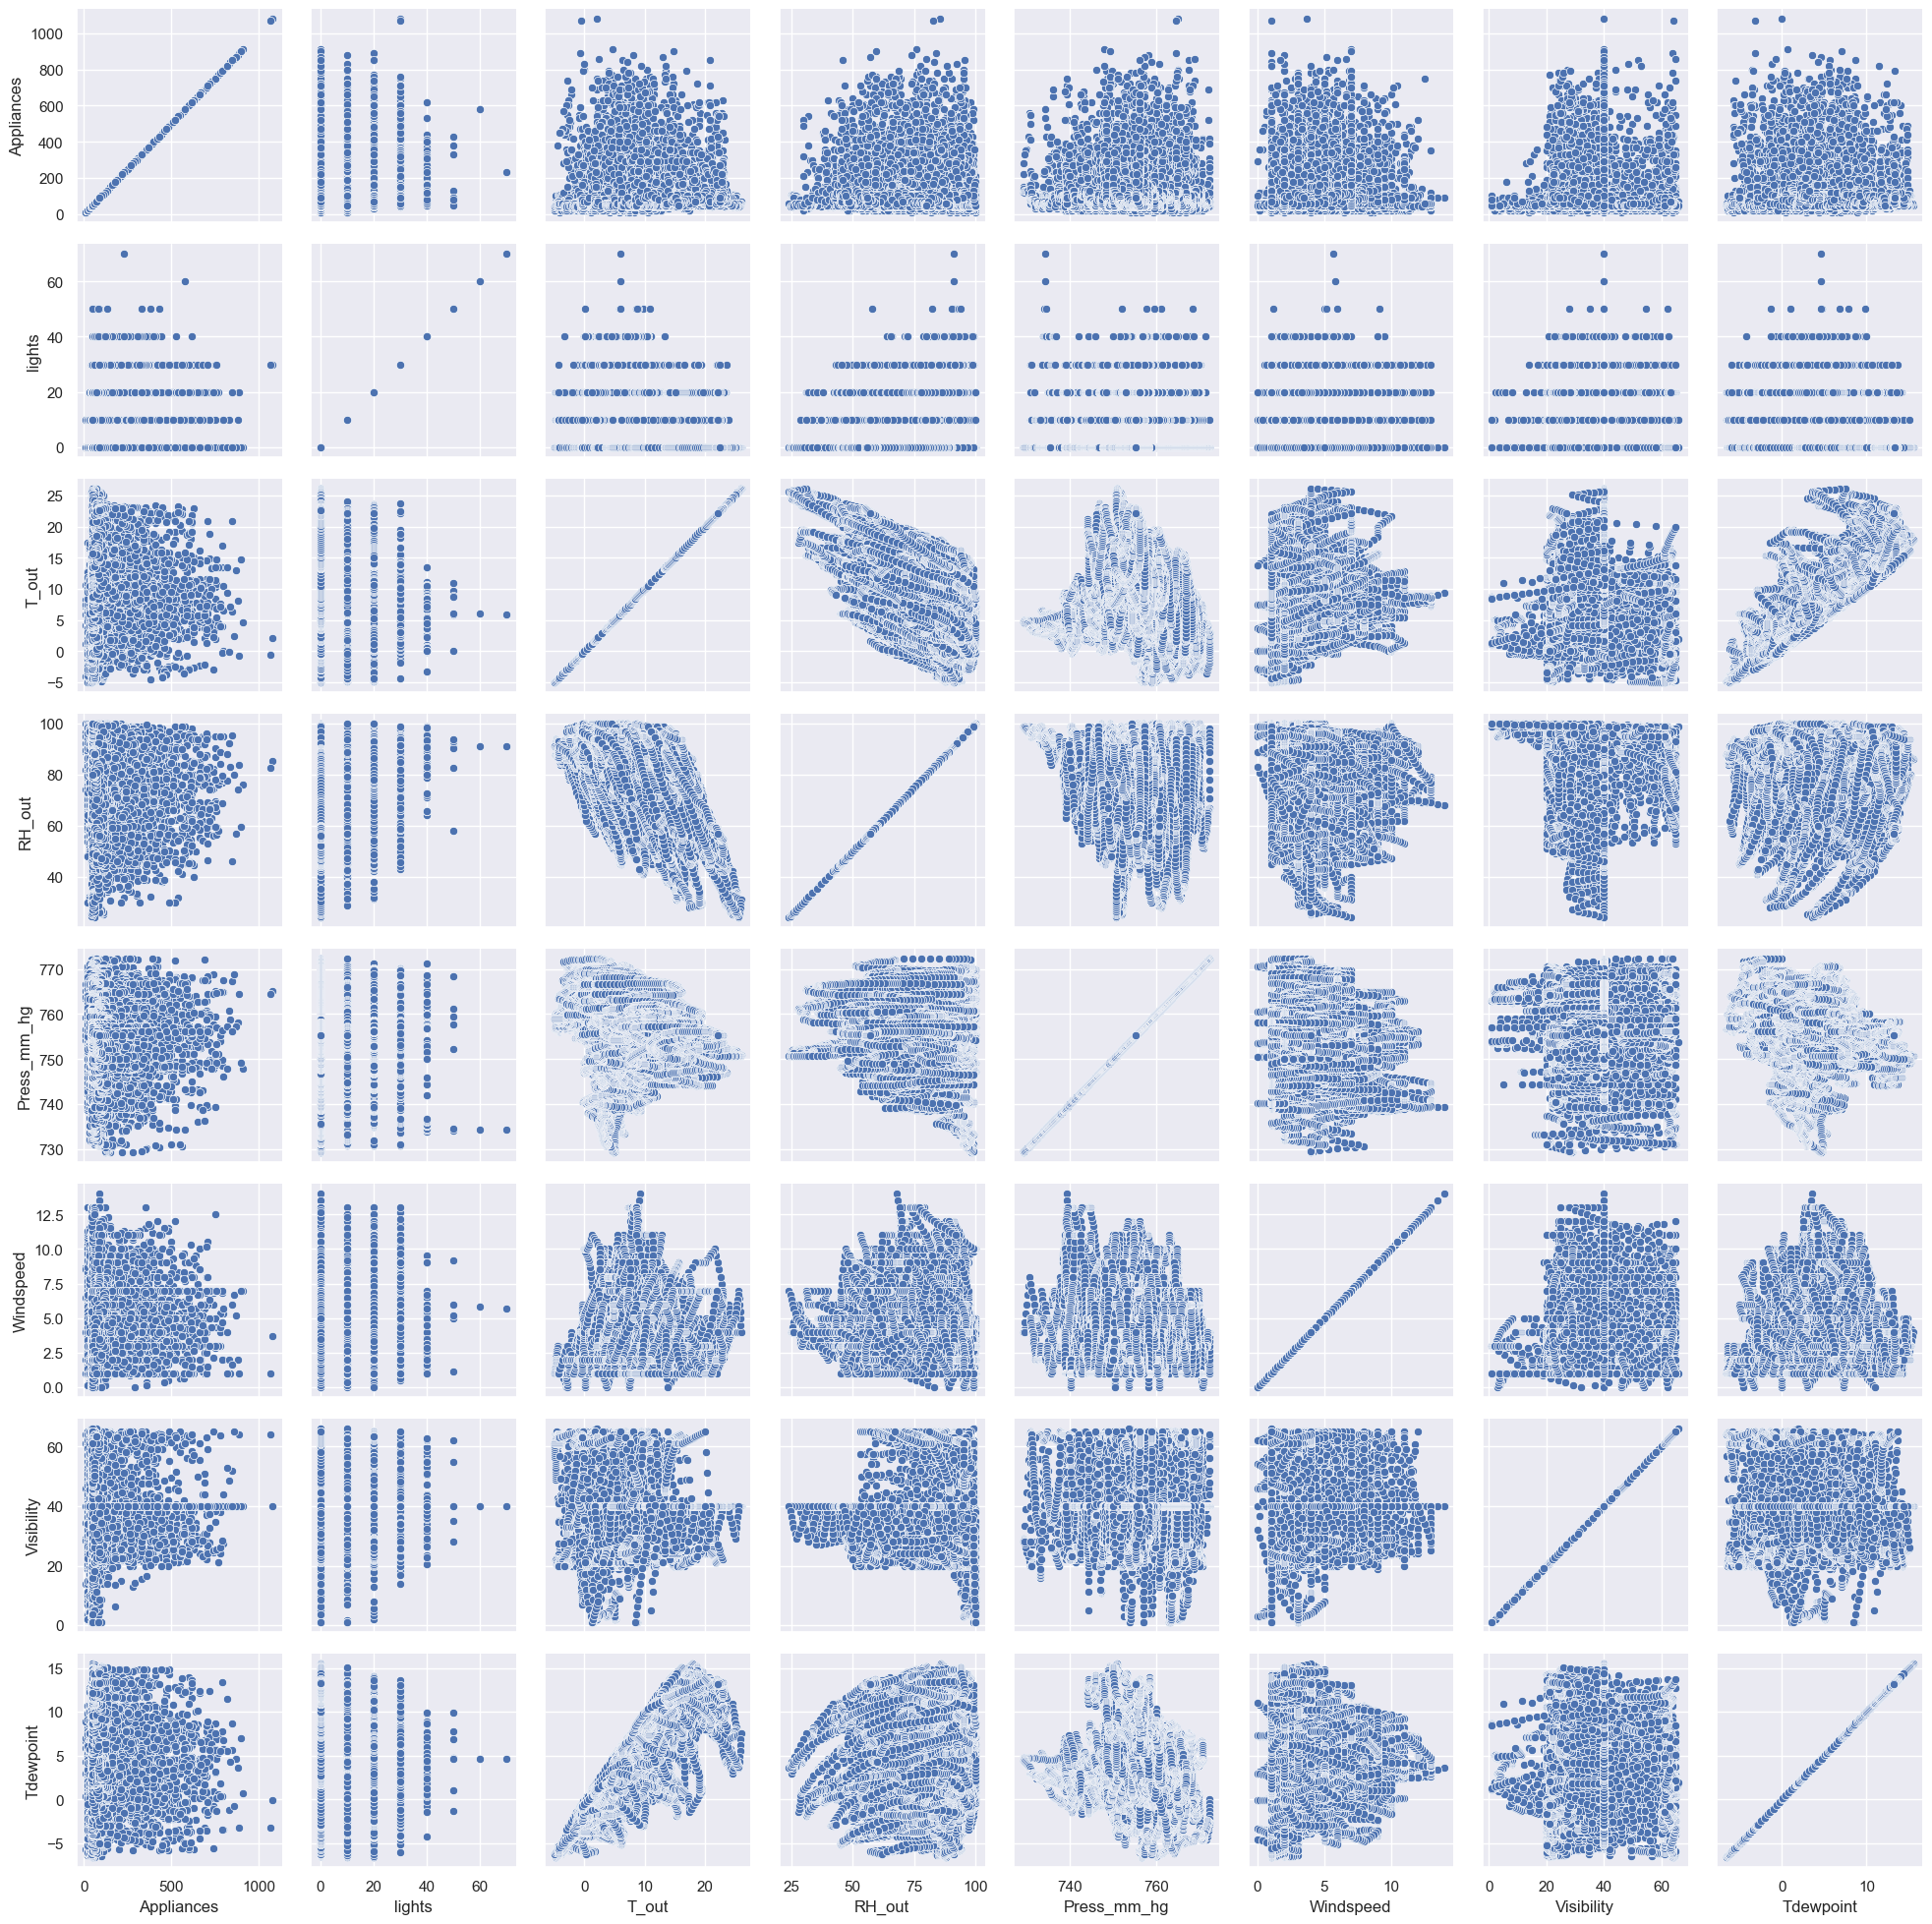

In [173]:
g = sns.PairGrid(sub_df)
g.map(sns.scatterplot)

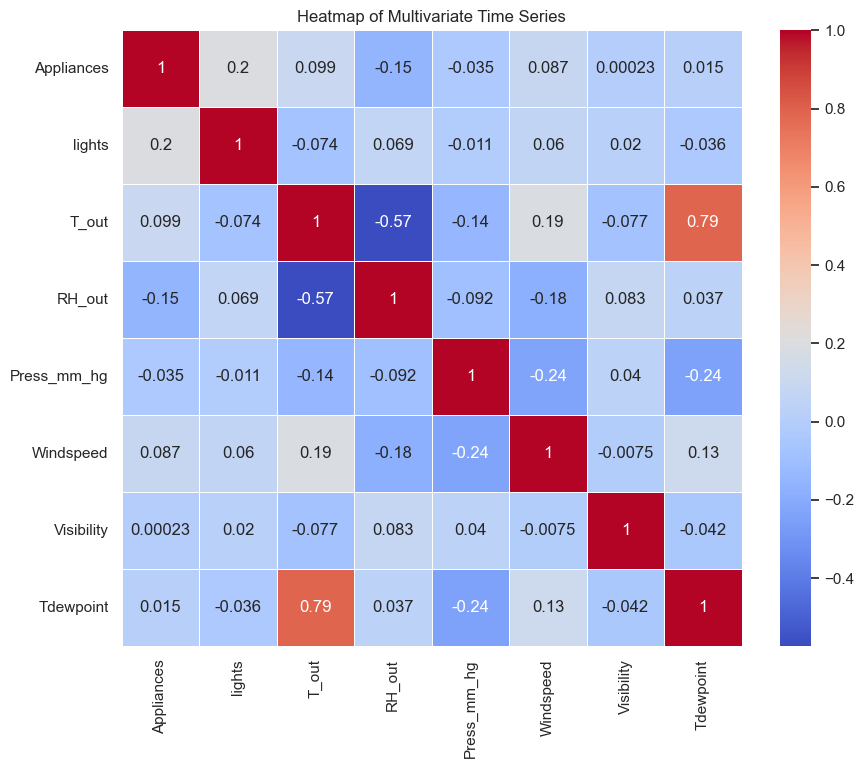

In [174]:
# Compute the correlation matrix
corr = sub_df.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Multivariate Time Series')
plt.show()

#### Tdewpoint and T_out exhibit a strong positive correlation, while RH_out and T_out show a moderate negative correlation.

### Check for Stationarity

In [175]:
# Define function for Stationary check
# code from https://www.kaggle.com/code/jurk06/auto-arima-on-multivariate-time-series
def check_stationarity(series, signif=0.05, name='', verbose=False):
    
    result = adfuller(series.values)
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [176]:
# ADF Test on each column
for name, column in sub_df.items():
    check_stationarity(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Appliances" 
    -----------------------------------------------
ADF Statistic: -21.616378
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "lights" 
    -----------------------------------------------
ADF Statistic: -21.575876
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "T_out" 
    -----------------------------------------------
ADF Statistic: -7.376707
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "RH_out" 
    -----------------------------------------------
ADF Statistic: -15.609493
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "Press_mm_hg" 
    -----------------------------------------------
ADF Statistic: -5.717286
p-value: 0.000001
Critical Values:

In [177]:
# code from https://phdinds-aim.github.io/time_series_handbook/03_VectorAutoregressiveModels/03_VectorAutoregressiveMethods.html

test_stat, p_val = [], []
cv_1pct, cv_5pct, cv_10pct = [], [], []
for c in sub_df.columns: 
    adf_res = adfuller(sub_df[c].dropna())
    test_stat.append(adf_res[0])
    p_val.append(adf_res[1])
    cv_1pct.append(adf_res[4]['1%'])
    cv_5pct.append(adf_res[4]['5%'])
    cv_10pct.append(adf_res[4]['10%'])
adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                           'p-value': p_val, 
                           'Critical value - 1%': cv_1pct,
                           'Critical value - 5%': cv_5pct,
                           'Critical value - 10%': cv_10pct}, 
                         index=sub_df.columns).T
adf_res_df.round(4)

Appliances   lights   T_out   RH_out  Press_mm_hg  \
Test statistic          -21.6164 -21.5759 -7.3767 -15.6095      -5.7173   
p-value                   0.0000   0.0000  0.0000   0.0000       0.0000   
Critical value - 1%      -3.4307  -3.4307 -3.4307  -3.4307      -3.4307   
Critical value - 5%      -2.8617  -2.8617 -2.8617  -2.8617      -2.8617   
Critical value - 10%     -2.5668  -2.5668 -2.5668  -2.5668      -2.5668   

                      Windspeed  Visibility  Tdewpoint  
Test statistic          -9.9432    -16.2291    -4.4440  
p-value                  0.0000      0.0000     0.0002  
Critical value - 1%     -3.4307     -3.4307    -3.4307  
Critical value - 5%     -2.8617     -2.8617    -2.8617  
Critical value - 10%    -2.5668     -2.5668    -2.5668

#### All are Stationary

#### When variables are stationary, their statistical properties such as mean and variance do not change over time. This implies that they revert to a long-term mean and have a constant variance.

### Inspect Correlograms

#### The Hurst exponent is a statistical measure used to assess the long-term memory of time series data. It quantifies the degree of autocorrelation within a time series, indicating how future values are influenced by past values.

- Values between 0.5 and 1: Indicate a persistent, trending time series. High values tend to be followed by high values, and low values by low values.
- Values between 0 and 0.5: Indicate an anti-persistent, mean-reverting time series. High values are likely followed by low values, and vice versa.
- Value of 0.5: Suggests a random walk, where future values are not dependent on past values

#### The Q-statistic (or Q-stat) is a test statistic used in time series analysis to test for the presence of autocorrelation at different lags.
- Low P-value (typically < 0.05): Reject the null hypothesis. This suggests that there is significant autocorrelation in the residuals, indicating that the model may not be adequately capturing all the patterns in the data.
- High P-value (typically > 0.05): Fail to reject the null hypothesis. This suggests that there is no significant autocorrelation in the residuals, indicating that the model is likely a good fit for the data

In [178]:
# code from https://goldinlocks.github.io/Multivariate-time-series-models/

# Hurst Exponent
def hurst(ts):
    lags = range(2, 100)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]*2.0
    
# Correlogram Plot
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

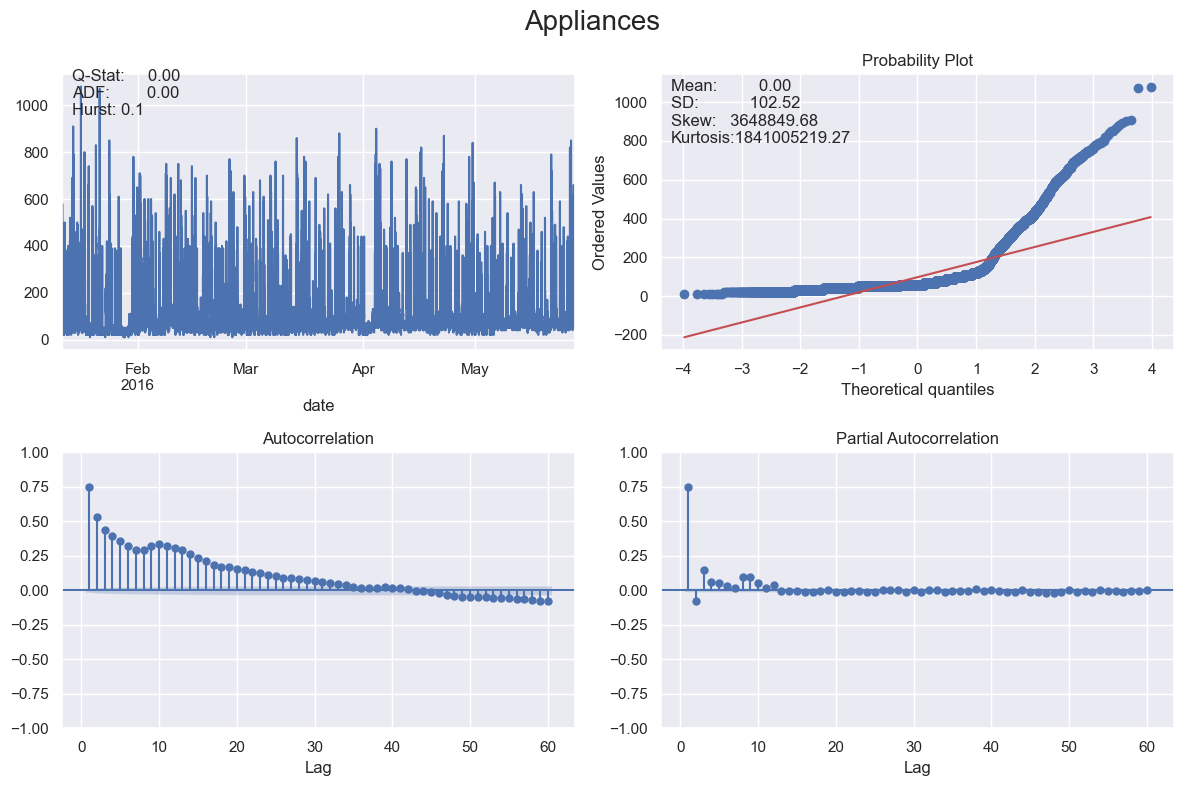

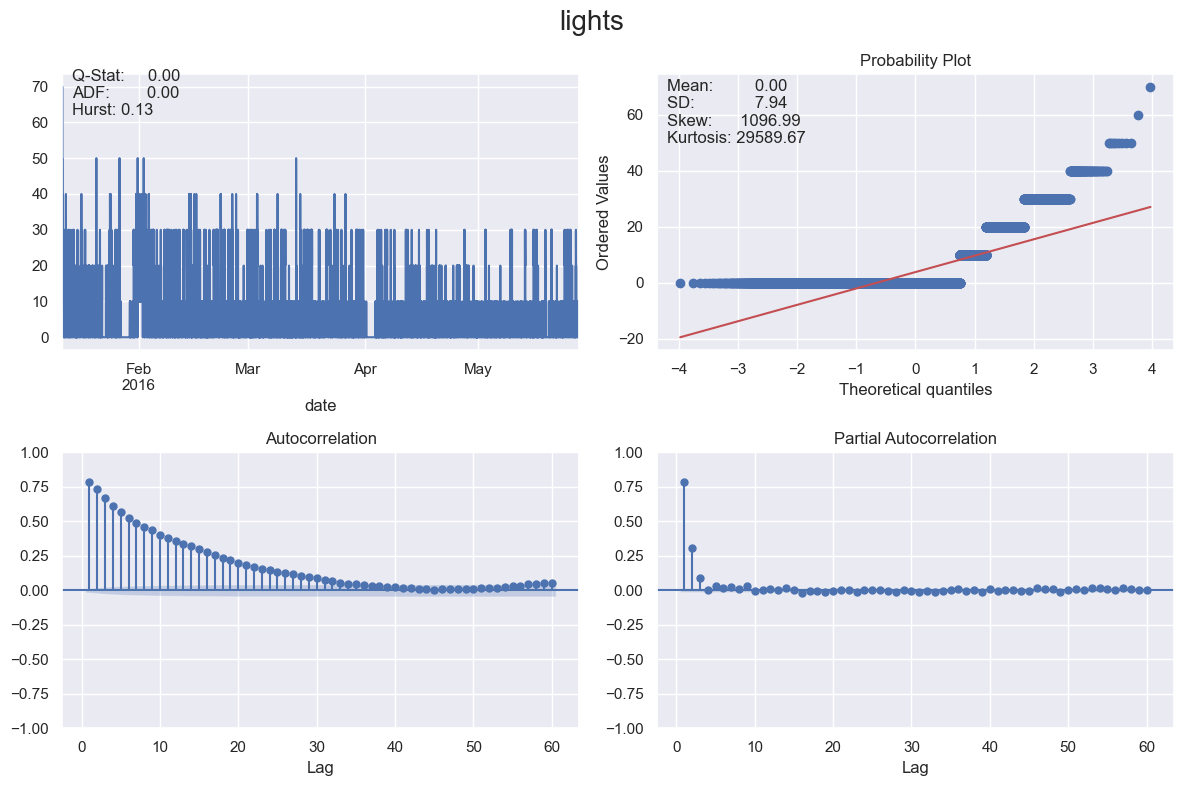

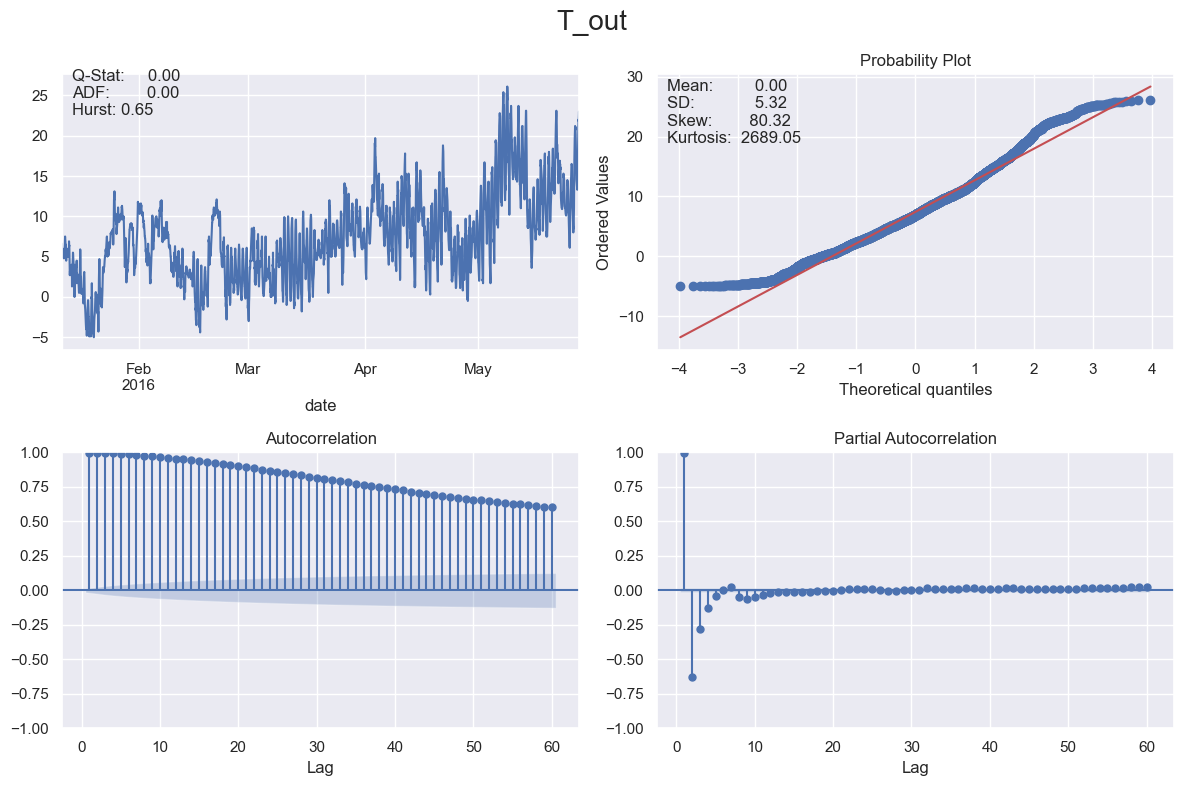

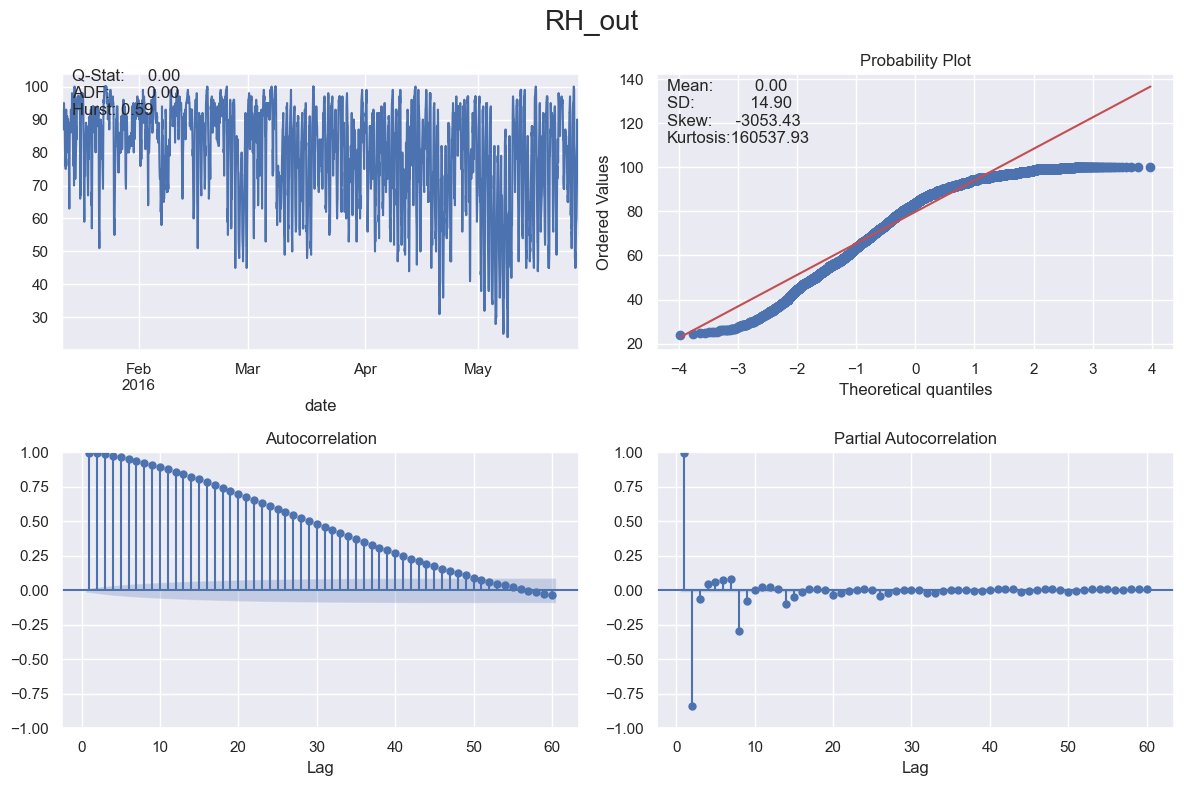

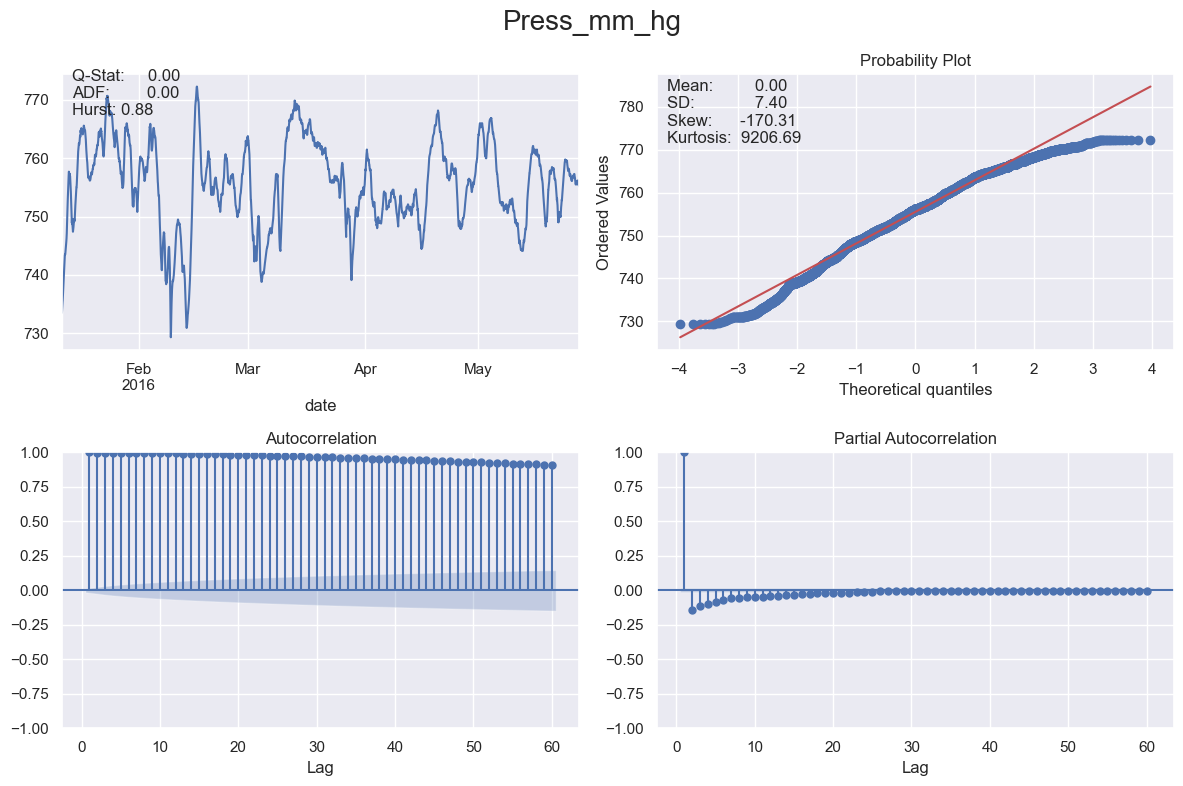

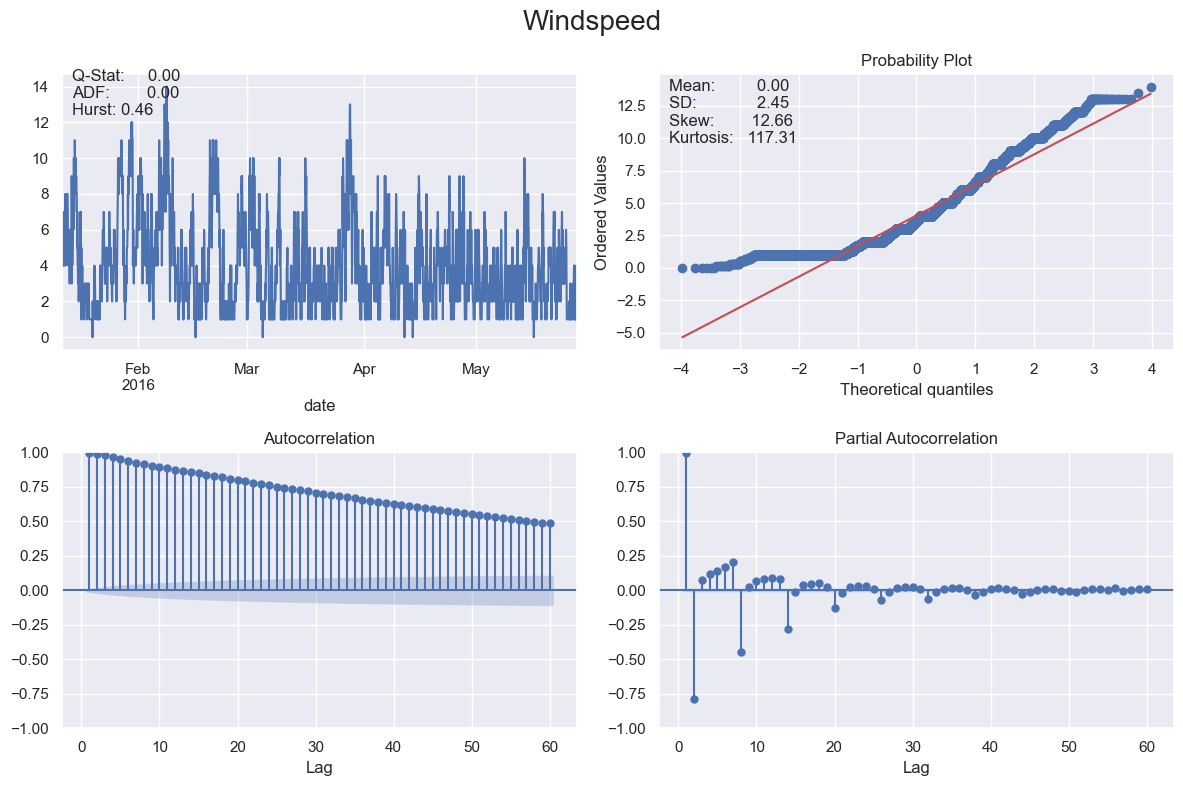

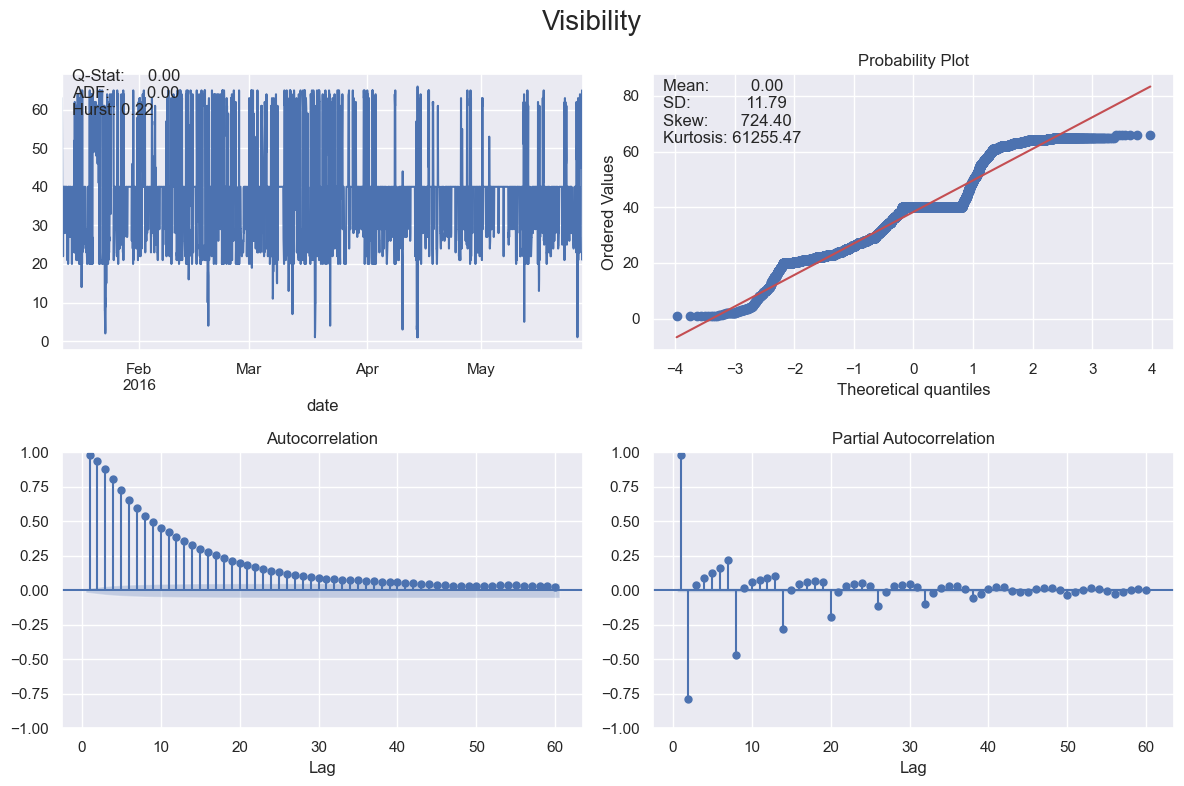

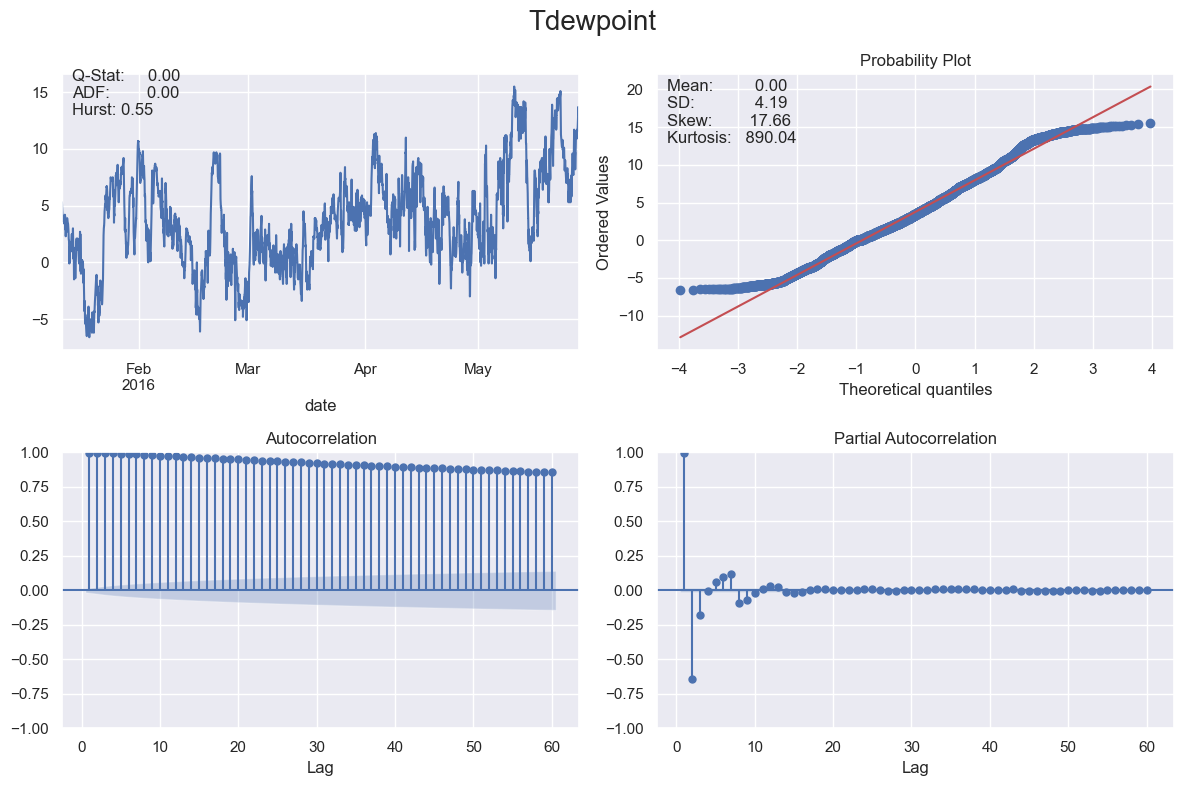

In [179]:
start_time = time.time()


for i in sub_df.columns:
    plot_correlogram(sub_df[i], lags=60, title=f'{i}')

end_time = time.time() - start_time

In [180]:
print(f"Plot correlogram took: {format_time(end_time)}")

Plot correlogram took: 0h 2m 6.50s


#### The ACF graphs shows spike above the blue region before 40 lags, which is an indication that the series is autocorrelated.

#### Optimal Batch Size?*
    By experience, in most cases, an optimal batch-size is 64. Nevertheless, there might be some cases where you select the batch size as 32, 64, 128 which must be dividable by 8. Note that this batch size fine-tuning must be done based on the performance observation.

##### *https://medium.com/@canerkilinc/selecting-optimal-lstm-batch-size-63066d88b96b

#### In order to do to train a LSTM model the training set size must a number which is dividable by the batch-size without the remainder.*
*https://medium.com/@canerkilinc/confining-lstm-train-set-size-based-on-batch-size-e2a965cac1

The number of epochs and batch size are crucial hyperparameters that significantly impact the performance of an LSTM model.

- Epochs
Accuracy and Error: Each epoch represents one complete pass through the entire training dataset. More epochs generally allow the model to learn better, reducing error and improving accuracy. However, too many epochs can lead to overfitting, where the model performs well on training data but poorly on unseen data.
Speed: Increasing the number of epochs will increase the training time since the model needs to process the entire dataset multiple times.
- Batch Size
- Accuracy and Error: Batch size determines the number of samples processed before the model’s internal parameters are updated. Smaller batch sizes can lead to more accurate updates but may introduce more noise, potentially improving generalization. Larger batch sizes provide more stable and accurate gradient estimates but may lead to poorer generalization.
- Speed: Larger batch sizes can speed up training because they make better use of hardware acceleration (like GPUs). However, they require more memory. Smaller batch sizes can slow down training but may converge faster in terms of epochs due to more frequent updates.
- Balancing Both
- Optimal Settings: Finding the right balance between epochs and batch size is key. Typically, a combination of a moderate number of epochs and a batch size that fits your hardware capabilities works well. Experimentation and cross-validation are essential to find the optimal settings for your specific dataset and model.

In [14]:
test_percent=0.2 # as an example
batch_size = 64 # as an example
def get_LSTM_train_size(df, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    number_of_samples = df.shape[0]
    print("# Shape of the input dataframe",number_of_samples)
    number_of_samples *= 1 - test_percent
    train_set_sizes = []
    for size in range(int(number_of_samples) - 100,int(number_of_samples)): 
        mod=size%batch_size
        if (mod == 0):
            train_set_sizes.append(size)
            print(size)
    return (max(train_set_sizes))

In [15]:
get_LSTM_train_size(sub_df, batch_size, test_percent)

# Shape of the input dataframe 19735
15744


15744

### Scaling and Split the Series into Training and Testing Data

#### it is generally necessary to normalize the data before using LSTM (Long Short-Term Memory) networks for time series forecasting. LSTMs are sensitive to the scale of the input data, especially when activation functions like sigmoid or tanh are used. Normalizing the data helps to ensure that the model trains more effectively and converges faster.

In [16]:
# Train-Test-Split
train_size = 15744

def splitter(data_df, size):
    train_df = data_df[:train_size]
    test_df = data_df[train_size:]
    return train_df, test_df

train_df, test_df = splitter(sub_df, train_size)
print(f'train size: {len(train_df)}, test size: {len(test_df)}')

train size: 15744, test size: 3991


### Create Sequences: Transform the time series data into sequences of a fixed length.

####  both inputs (X) and outputs (y) are 3-dimensional arrays, you're dealing with a sequence-to-sequence (Seq2Seq) prediction problem. In this scenario, the model takes a sequence of inputs and predicts a sequence of outputs, with both sequences possibly having multiple features.

In [17]:
# Reformat input data into a shape: (n_samples x timesteps x n_features)

def create_sequences(data, n_past_days, n_future_days, period=10):
    """
    Create input and output sequences for a multivariate LSTM.
    
    Parameters:
    - data: NumPy array of shape (n_samples, n_features), the multivariate time series data.
    - n_past_days: Number of past days to use as input.
    - n_future_days: Number of future days to predict.
    - period: Time period in minutes (default: 10 minutes).
    
    Returns:
    - X: NumPy array of input sequences of shape (n_samples, n_past, n_features)
    - y: NumPy array of output sequences of shape (n_samples, n_future, n_features)
    """
    # Calculate the number of timesteps in a day
    timesteps_per_day = 24 * 60 // period
    
    # Convert n_past_days and n_future_days into number of time steps
    n_past = n_past_days * timesteps_per_day
    n_future = n_future_days * timesteps_per_day
    
    X, y = [], []
    
    for i in range(n_past, len(data) - n_future):
        # Create input sequence (n_past timesteps, all features)
        X.append(data[i - n_past:i])
        
        # Create output sequence (n_future timesteps, all features)
        y.append(data[i:i + n_future])
    
    return np.array(X), np.array(y)

In [18]:
# Since there are 144 ten-minute intervals in a day for this dataset ; for a single hour, you will have 6 observations

n_past_days = 10   # Use 10 past days for prediction
n_future_days = 1 # Predict 1 day into the future

#Reformat input data into a shape: (n_samples x timesteps x n_features)
trainX, trainY = create_sequences(train_df, n_past_days=10, n_future_days=1)
print(f'trainX shape = {trainX.shape}, \ntrainY shape ={trainY.shape}')

trainX shape = (14160, 1440, 8), 
trainY shape =(14160, 144, 8)


In [19]:
testX, testY = create_sequences(test_df, n_past_days=10, n_future_days=1)
print(f'testX shape = {testX.shape}, \ntestY shape ={testY.shape}')

testX shape = (2407, 1440, 8), 
testY shape =(2407, 144, 8)


In [20]:
# All the columns in the data frame are on a different scale. Now we will scale the values to -1 to 1
# temperature has negative numbers
 # using MinMaxScaler because the data range is very high, and they are not scaled in a same range

def scale_3d_series(data, column_names):
    """
    Scales a 3D series using MinMaxScaler for each feature.

    Parameters:
    data (np.ndarray): The input 3D array with shape (samples, time steps, features).

    Returns:
    np.ndarray: The scaled 3D array.
    list: List of fitted scalers for each feature.
    """
    n_samples, n_timesteps, n_features = data.shape
    scaled_data = np.zeros_like(data)
    scalers={}

    for feature, c in enumerate(column_names):
        scaler = MinMaxScaler(feature_range=(-1,1))
        # Reshape data to 2D array (samples*time steps, 1)
        feature_data = data[:, :, feature].reshape(-1, 1)
        scaled_feature_data = scaler.fit_transform(feature_data)
        # Reshape back to 3D array
        scaled_data[:, :, feature] = scaled_feature_data.reshape(n_samples, n_timesteps)
        scalers['scaler_'+ c] = scaler

    return scaled_data, scalers

trainX_scaled, trainX_scalers = scale_3d_series(trainX, sub_df.columns)
print(f'trainX_scaled shape = {trainX_scaled.shape}')

trainX_scaled shape = (14160, 1440, 8)


In [21]:
trainY_scaled, trainY_scalers = scale_3d_series(trainY, sub_df.columns)
print(f'trainY_scaled shape = {trainY_scaled.shape}')

trainY_scaled shape = (14160, 144, 8)


In [22]:
testX_scaled, testX_scalers = scale_3d_series(testX, sub_df.columns)
print(f'testX_scaled shape = {testX_scaled.shape}')

testX_scaled shape = (2407, 1440, 8)


In [23]:
testY_scaled, testY_scalers = scale_3d_series(testY, sub_df.columns)
print(f'testY_scaled shape = {testY_scaled.shape}')

testY_scaled shape = (2407, 144, 8)


In [24]:
testX_scalers

{'scaler_Appliances': MinMaxScaler(feature_range=(-1, 1)),
 'scaler_lights': MinMaxScaler(feature_range=(-1, 1)),
 'scaler_T_out': MinMaxScaler(feature_range=(-1, 1)),
 'scaler_RH_out': MinMaxScaler(feature_range=(-1, 1)),
 'scaler_Press_mm_hg': MinMaxScaler(feature_range=(-1, 1)),
 'scaler_Windspeed': MinMaxScaler(feature_range=(-1, 1)),
 'scaler_Visibility': MinMaxScaler(feature_range=(-1, 1)),
 'scaler_Tdewpoint': MinMaxScaler(feature_range=(-1, 1))}

### Define the Bidirectional stacked LSTM model

In [47]:
# Stacked LSTMs involve multiple LSTM layers, allowing the model to learn more complex patterns in the data.

model = Sequential()
model.add(Bidirectional(LSTM(128, input_shape=(trainX_scaled.shape[1], trainX_scaled.shape[2]), return_sequences=True)) )
model.add(Bidirectional(LSTM(64, return_sequences=False)) )  # Return only the final output
model.add(Dropout(0.3))
# Repeat the vector n_future times (this is necessary to predict n_future time steps)
model.add(RepeatVector(trainY_scaled.shape[1]))  # Number of future timesteps
model.add(Bidirectional(LSTM(32, return_sequences=True)) )
model.add(Dropout(0.3))
model.add(Dense(units=16, activation='relu')), 
model.add(TimeDistributed(Dense(trainY_scaled.shape[2])) )  

# TimeDistributed Dense Layer: Applies a fully connected layer to each time step in the sequence output by the last LSTM layer.

In [48]:
# Compile the model 
model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

In [49]:
from tensorflow.keras.callbacks import EarlyStopping
# monitor:	Quantity to be monitored
# patience: 	Number of epochs with no improvement after which training will be stopped
# mode:  In min mode, training will stop when the quantity monitored has stopped decreasing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# fit the model- Train the model
history = model.fit(trainX_scaled, trainY_scaled, epochs=20, batch_size=64,  validation_data=(testX_scaled, testY_scaled) ,shuffle=False,
    callbacks = [early_stopping], verbose=1)

Epoch 1/20
222/222 [==============================] - 96s 397ms/step - loss: 0.1595 - mean_absolute_error: 0.3140 - val_loss: 0.1843 - val_mean_absolute_error: 0.3283
Epoch 2/20
222/222 [==============================] - 85s 383ms/step - loss: 0.1251 - mean_absolute_error: 0.2768 - val_loss: 0.1839 - val_mean_absolute_error: 0.3240
Epoch 3/20
222/222 [==============================] - 85s 382ms/step - loss: 0.1220 - mean_absolute_error: 0.2718 - val_loss: 0.1708 - val_mean_absolute_error: 0.3146
Epoch 4/20
222/222 [==============================] - 85s 384ms/step - loss: 0.1182 - mean_absolute_error: 0.2671 - val_loss: 0.1690 - val_mean_absolute_error: 0.3137
Epoch 5/20
222/222 [==============================] - 85s 383ms/step - loss: 0.1134 - mean_absolute_error: 0.2611 - val_loss: 0.1646 - val_mean_absolute_error: 0.3095
Epoch 6/20
222/222 [==============================] - 85s 382ms/step - loss: 0.1112 - mean_absolute_error: 0.2585 - val_loss: 0.1642 - val_mean_absolute_error: 0.312

In [195]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 1440, 256)        140288    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 144, 128)         0         
 or)                                                             
                                                                 
 bidirectional_8 (Bidirectio  (None, 144, 64)          41216     
 nal)                                                 

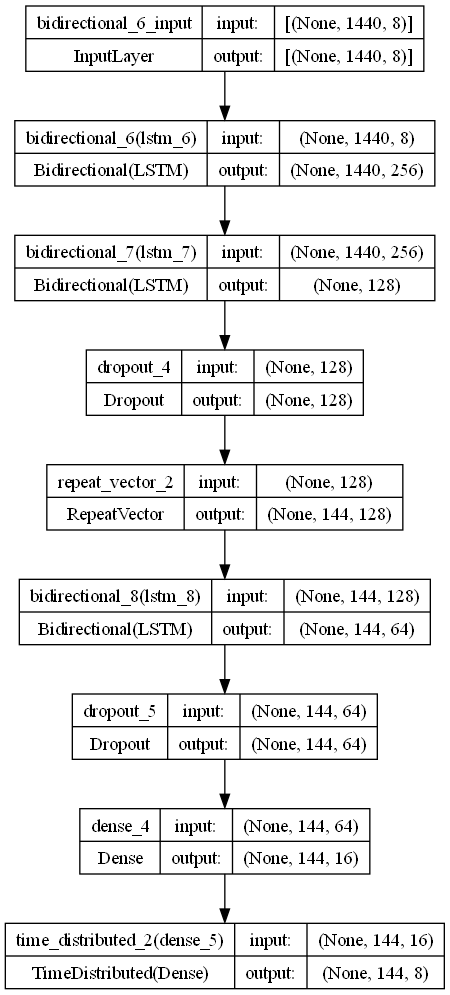

In [196]:
#!pip install pydot==2.0.0
#conda install graphviz

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='LSTMmodel_plot.png', show_shapes=True, show_layer_names=True)

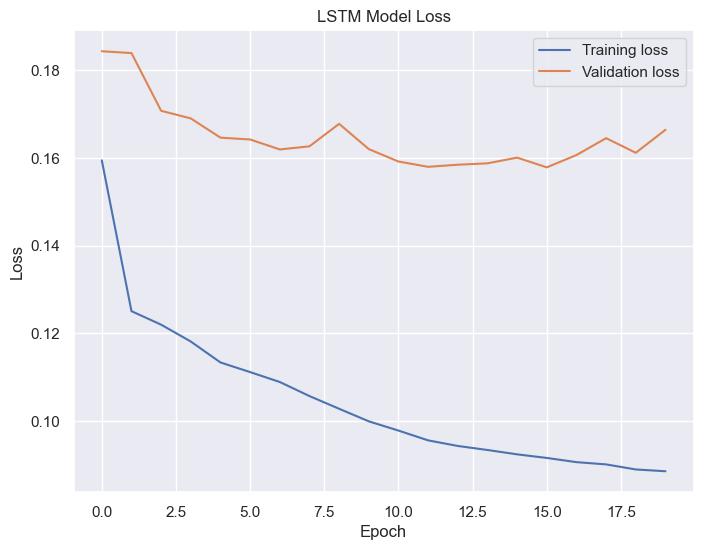

In [50]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### General Scenarios:

- Overfitting: Training loss goes down, but validation loss starts rising.
- Good fit: Both training and validation loss decrease and stabilize near each other.
- Underfitting: Both losses are high and don't decrease much over time.

#### In summary:

- val_loss > loss: Normal scenario, but watch out for overfitting if the gap grows too large.
- val_loss < loss: Can happen early in training or if the model generalizes well to validation data.

In [51]:
# Prediction on test samples
y_pred = model.predict(testX_scaled)
print(y_pred.shape)   #   Predicted values (n_samples, n_future, n_features)

76/76 [==============================] - 13s 154ms/step
(2407, 144, 8)


In [52]:
def inverse_scale_3d_series(scaled_data, scalers, column_names):
    """
    Inverse scales a 3D series using the provided scalers for each feature.

    Parameters:
    scaled_data (np.ndarray): The scaled 3D array with shape (samples, time steps, features).
    scalers (list): List of fitted MinMaxScaler objects for each feature.

    Returns:
    np.ndarray: The inverse scaled 3D array.
    """
    n_samples, n_timesteps, n_features = scaled_data.shape
    inverse_scaled_data = np.zeros_like(scaled_data)

    for feature, c in enumerate(column_names):
        scaler = scalers['scaler_'+ c]
        # Reshape data to 2D array (samples*time steps, 1)
        feature_data = scaled_data[:, :, feature].reshape(-1, 1)
        inverse_scaled_feature_data = scaler.inverse_transform(feature_data)
        # Reshape back to 3D array
        inverse_scaled_data[:, :, feature] = inverse_scaled_feature_data.reshape(n_samples, n_timesteps)

    return inverse_scaled_data

In [53]:
inverse_scaled_y_pred = inverse_scale_3d_series(y_pred, testX_scalers, sub_df.columns)
print(inverse_scaled_y_pred.shape)

(2407, 144, 8)


In [54]:
inverse_scaled_y_true = inverse_scale_3d_series(testY_scaled, testY_scalers, sub_df.columns)
print(inverse_scaled_y_pred.shape)

(2407, 144, 8)


In [55]:
def evaluate_model(columns, y_true, y_pred):
    """
    Evaluate the model using MAE, MSE, RMSE, and MAPE per feature.
    
    Parameters:
    - y_true: True values (n_samples, n_future, n_features).
    - y_pred: Predicted values (n_samples, n_future, n_features).
    
    Returns:
    - metrics: Dictionary containing MAE, MSE, RMSE, and MAPE for each feature.
    """
    metrics = {}

    for i, c in enumerate(columns):
        # Extract true and predicted values for each feature
        true = y_true[:, :, i].flatten()  # Reshape to 2D arrays
        pred = y_pred[:, :, i].flatten()

        # Calculate metrics
        mae = mean_absolute_error(true, pred)
        mse = mean_squared_error(true, pred)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(true, pred)

        # Store metrics per feature
        metrics[c] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape
        }
    
    return metrics

##### flatten(): This method creates a copy of the original array and flattens it into a 1D array.
##### ravel(): This method can return a view of the original array if possible, making it more memory efficient than flatten().
##### reshape(): This method allows you to change the shape of an array without changing its data. reshape(-1): This is a shortcut to automatically calculate one of the dimensions.

#### Evaluation metrics*

    In time series forecasting, to evaluate the models, a comprehensive evaluation criterion is essential to measure the performance of the model. Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), Mean Squared Error (MSE) and Mean Absolute Percentage Error (MAPE) are commonly used metrics to reliably evaluate the performance of the models.

- RMSE is that it penalizes large errors and scales the scores in the same units as the forecast values.
- MSE is the squared form of RMSE and is commonly used as a regression loss function.
- MAE generally, outperforms RMSE for measuring an average model accuracy.
- MAPE is the average of absolute percentage errors which is popular in the industry since it is scale-independent and easy to interpret.

*from https://towardsdatascience.com/vector-auto-regression-for-multivariate-time-series-forecasting-cf5216c9ce23

In [56]:
metrics = evaluate_model(sub_df.columns, inverse_scaled_y_true, inverse_scaled_y_pred)
# Print metrics for each feature
for feature, vals in metrics.items():
    print(f"{feature}: {vals}")

Appliances: {'MAE': 54.748428827168425, 'MSE': 8876.98368500852, 'RMSE': 94.21774612570881, 'MAPE': 0.5917918206850412}
lights: {'MAE': 3.521632367639541, 'MSE': 34.56143329728679, 'RMSE': 5.878897285825531, 'MAPE': 8158869434133893.0}
T_out: {'MAE': 3.2422111549965376, 'MSE': 16.259925966436622, 'RMSE': 4.03235985081151, 'MAPE': 0.2719883155038898}
RH_out: {'MAE': 13.742584527825608, 'MSE': 253.60185432469288, 'RMSE': 15.924881611010264, 'MAPE': 0.19367505804473853}
Press_mm_hg: {'MAE': 2.9681458044679, 'MSE': 15.33795064850996, 'RMSE': 3.9163695750669345, 'MAPE': 0.0039521230176080184}
Windspeed: {'MAE': 1.4235097256101168, 'MSE': 3.297661406213956, 'RMSE': 1.8159464216253618, 'MAPE': 5374896651436.231}
Visibility: {'MAE': 7.587751046203486, 'MSE': 101.969485231064, 'RMSE': 10.097994119183472, 'MAPE': 0.3426409888657741}
Tdewpoint: {'MAE': 3.2067719482912755, 'MSE': 14.338740210172341, 'RMSE': 3.7866529033134713, 'MAPE': 0.5442842027213215}


In [57]:
pd.DataFrame.from_dict(metrics, orient='index').T

Appliances        lights      T_out      RH_out  Press_mm_hg  \
MAE     54.748429  3.521632e+00   3.242211   13.742585     2.968146   
MSE   8876.983685  3.456143e+01  16.259926  253.601854    15.337951   
RMSE    94.217746  5.878897e+00   4.032360   15.924882     3.916370   
MAPE     0.591792  8.158869e+15   0.271988    0.193675     0.003952   

         Windspeed  Visibility  Tdewpoint  
MAE   1.423510e+00    7.587751   3.206772  
MSE   3.297661e+00  101.969485  14.338740  
RMSE  1.815946e+00   10.097994   3.786653  
MAPE  5.374897e+12    0.342641   0.544284

#### NOTE: MAPE output is non-negative floating point. The best value is 0.0. But note that bad predictions can lead to arbitrarily large MAPE values, especially if some y_true values are very close to zero.

#### MAE, MSE, RMSE output is non-negative floating point. The best value is 0.0

In [58]:
def plot_3d_series(y_true, y_pred, feature_names=None):
    """
    Plots the true and predicted values for each feature over time.

    Parameters:
    y_true (np.ndarray): The true values (3D array with shape (samples, time steps, features)).
    y_pred (np.ndarray): The predicted values (3D array with shape (samples, time steps, features)).
    feature_names (list, optional): List of feature names for labeling the plots.
    """
    n_samples, n_timesteps, n_features = y_true.shape

    if feature_names is None:
        feature_names = [f'Feature {i+1}' for i in range(n_features)]

    for feature in range(n_features):
        plt.figure(figsize=(10, 6))
        plt.plot(y_true[:, :, feature].flatten(), label='True', linewidth=0.5)
        plt.plot(y_pred[:, :, feature].flatten(), label='Predicted', linewidth=0.5)
        plt.title(f"Test vs Predicted Data for {feature_names[feature]} Over Time")
        plt.xlabel("Time Step")
        plt.ylabel(feature_names[feature])
        plt.legend()
        plt.show()

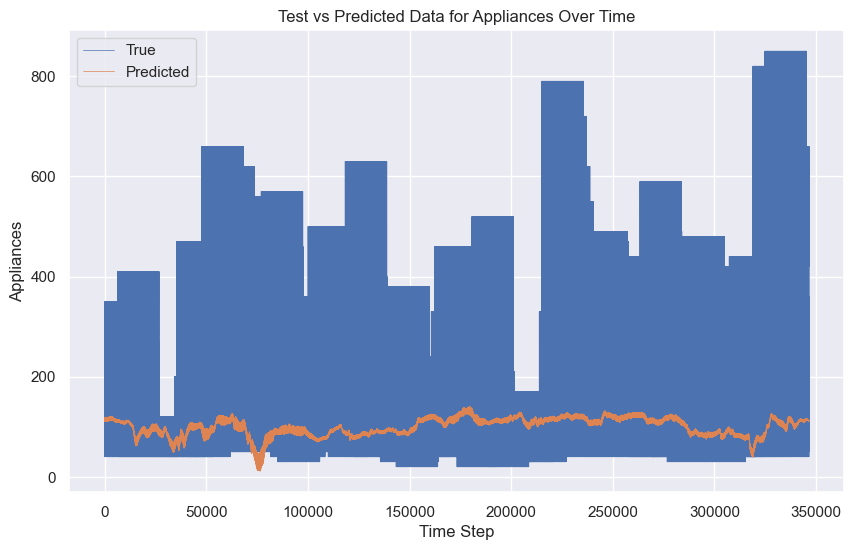

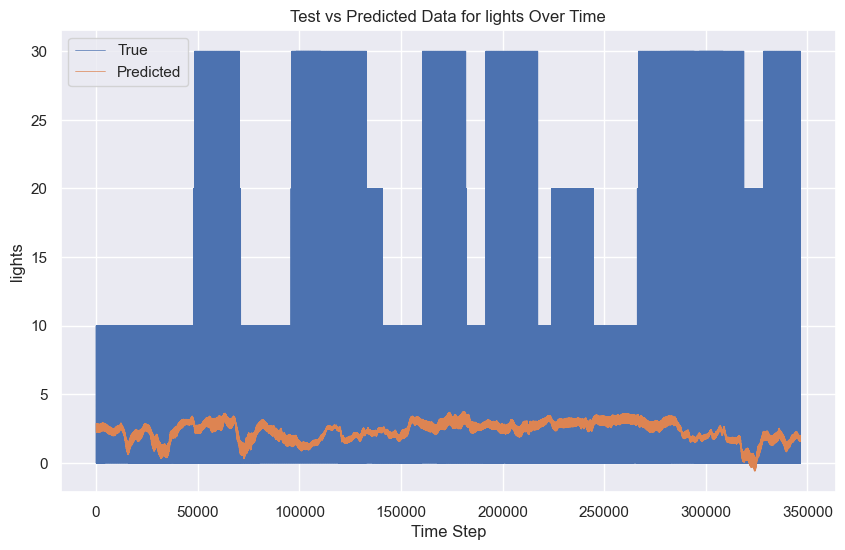

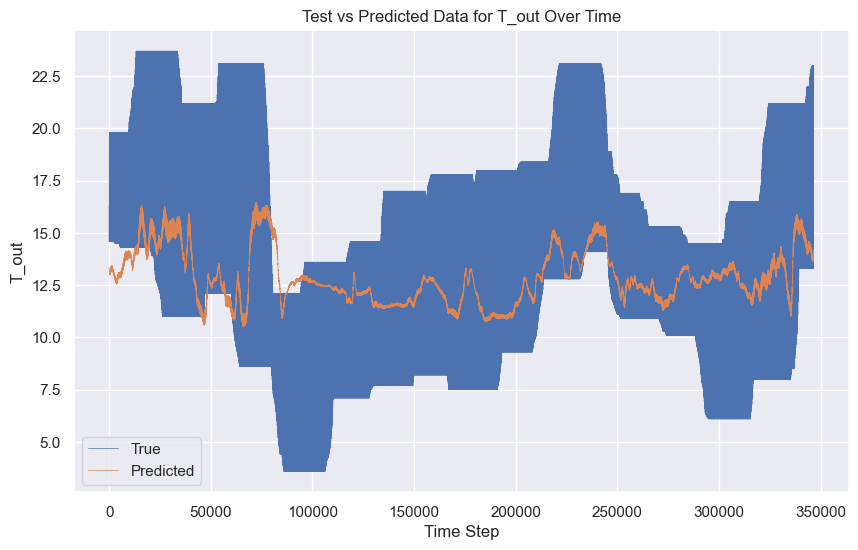

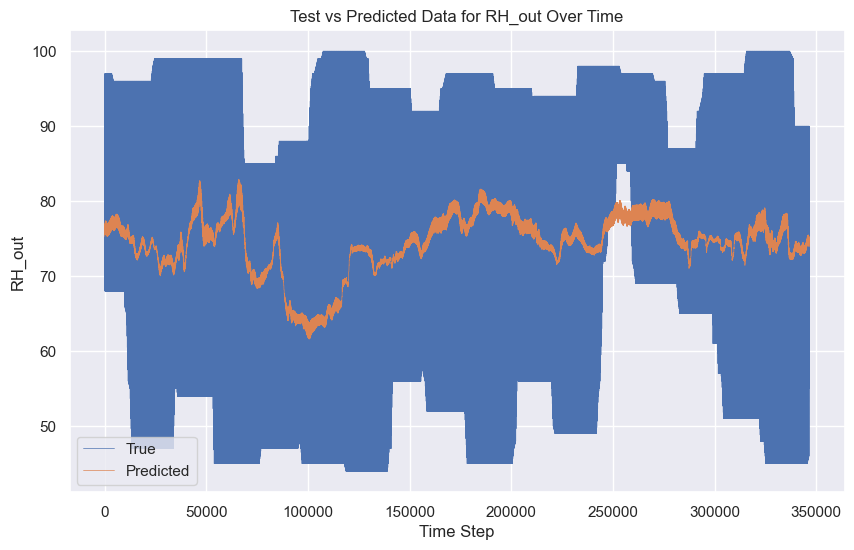

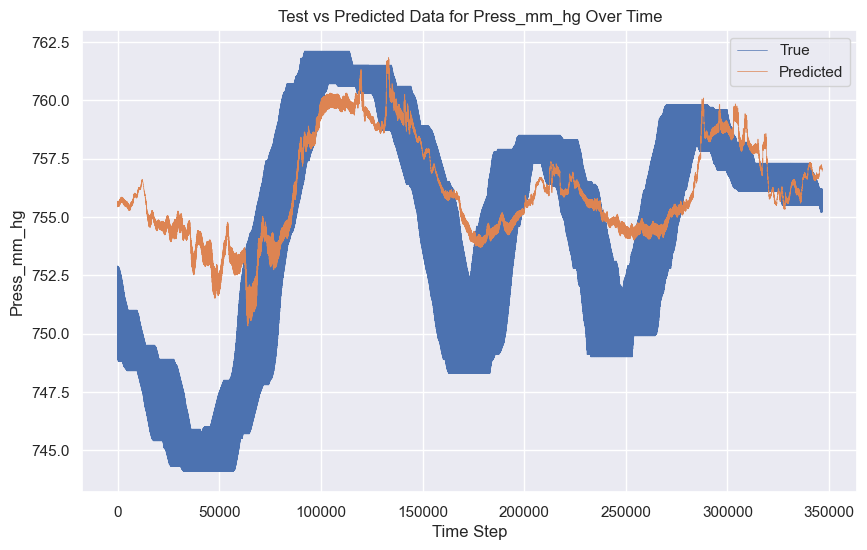

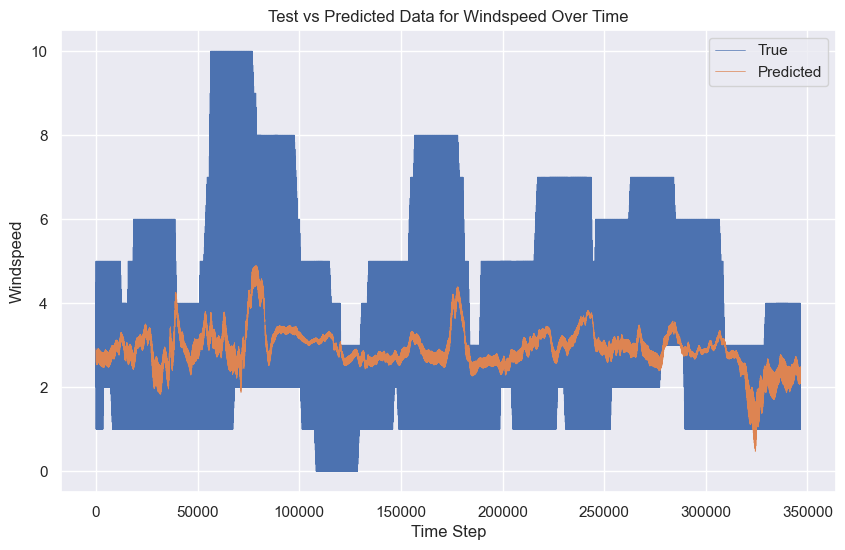

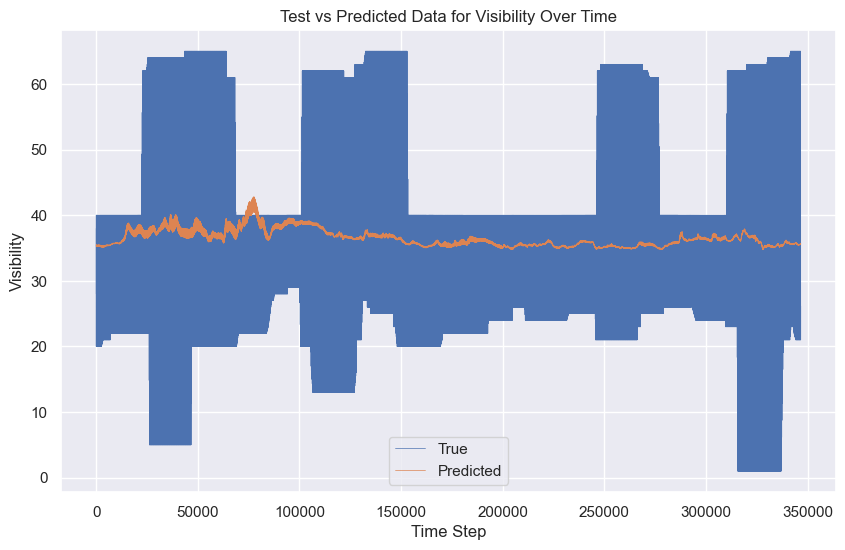

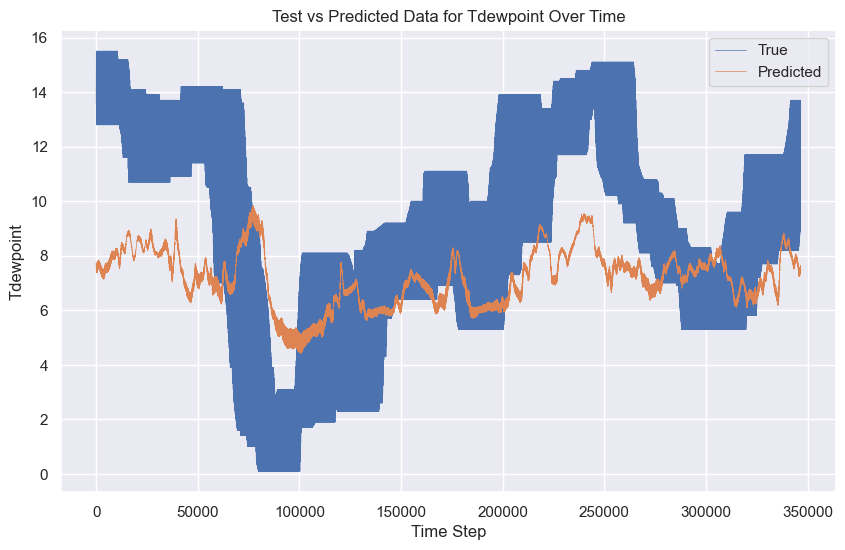

In [59]:
plot_3d_series(inverse_scaled_y_true, inverse_scaled_y_pred, feature_names=sub_df.columns)

### Bayesian Optimization

#### Further readings:
    
    https://www.kaggle.com/code/clemwo/battle-of-bayesian-optimization-methods/notebook
    https://drlee.io/bayesian-optimization-with-python-b544255757d3
    https://towardsdatascience.com/bayesian-optimization-concept-explained-in-layman-terms-1d2bcdeaf12f
    https://medium.com/@hanishpaturi/bayesian-optimization-simplified-master-advanced-hyperparameter-tuning-for-machine-learning-547f9c905c25
    https://medium.com/@fmnobar/hyperparameter-optimization-with-hyperband-30x-faster-than-bayesian-optimization-d6f01e7e6d0f
    
    https://machinelearningmastery.com/scikit-optimize-for-hyperparameter-tuning-in-machine-learning/
    https://machinelearningmastery.com/what-is-bayesian-optimization/
    
    https://medium.com/@icaro_vazquez/neural-network-hyperparameter-optimization-with-hyperopt-f3e0cb4346c8
    
    https://forecastegy.com/posts/multiple-time-series-forecasting-with-lstm-in-python/

#### Here's a comparison of four popular libraries:

|Feature/Library|	Optuna|	BayesianOptimization|	Hyperopt|	GP_minimize|
| :-- | :-- | :-- | :-- | :-- | 
|Ease of Use|	Moderate|	Easy|	Moderate|	Easy|
|Flexibility|	High|	Moderate|	High|	Low|
|Pruning (Early Stopping)|	Yes|	No|	No|	No|
|Parallelism|	Yes|	Limited|	Yes|	No|
|Scalability|	High|	Moderate|	High|	Low|
|Default Surrogate Model|	TPE|	Gaussian Processes|	TPE/Random Search|	Gaussian Processes|
|Acquisition Function Options|	Flexible|	Flexible|	Limited|	Limited|
|Integration|	TensorFlow, PyTorch, etc.|	Limited|	MongoDB, Spark|	Scikit-Learn|

In [207]:
# https://optuna.org/
#!pip install optuna-integration[tfkeras]

In [25]:
import optuna
from optuna.integration import TFKerasPruningCallback

In [26]:

def create_model(input_shape, output_shape, learning_rate):
    model = Sequential()
    model.add(InputLayer(input_shape))
    model.add(Bidirectional(LSTM(128, return_sequences=True)) )
    model.add(Bidirectional(LSTM(64, return_sequences=False)) )  # Return only the final output
    model.add(Dropout(0.3))
    model.add(RepeatVector(output_shape.shape[1]))  # Number of future timesteps
    model.add(Bidirectional(LSTM(32, return_sequences=True)) )
    model.add(Dropout(0.3))
    model.add(Dense(units=16, activation='relu')), 
    model.add(TimeDistributed(Dense(output_shape.shape[2])) )  
    model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    metrics=[tf.metrics.MeanAbsoluteError()])
    return model

In [27]:
def objective(trial):
    epoch = trial.suggest_int('epoch', 50, 100, step=10)
    batch_size = trial.suggest_int('batch_size', 16, 64, step=16)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2 )  # learning_rate: Adams defaults to a value of 0.001

    model = create_model(input_shape=(trainX_scaled.shape[1], trainX_scaled.shape[2]), output_shape=trainY_scaled, learning_rate=learning_rate)
    
    history = model.fit(trainX_scaled, trainY_scaled,
                        epochs=epoch,
                        batch_size=batch_size,
                        validation_split=0.2, shuffle=False,
                        verbose=0,
                        callbacks=[TFKerasPruningCallback(trial, 'val_loss')])

    val_loss = min(history.history['val_loss'])
    
    return val_loss

In [28]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print("Best hyperparameters: ", study.best_params)

[I 2024-09-10 08:55:25,479] A new study created in memory with name: no-name-9b1ccc9b-e933-40fd-8c33-02ebc81e8b15
[I 2024-09-10 15:11:52,067] Trial 0 finished with value: 0.09085389226675034 and parameters: {'epoch': 90, 'batch_size': 16, 'learning_rate': 0.0010261127864654212}. Best is trial 0 with value: 0.09085389226675034.
[I 2024-09-10 21:02:23,910] Trial 1 finished with value: 0.08780311793088913 and parameters: {'epoch': 80, 'batch_size': 16, 'learning_rate': 0.0016116282944972085}. Best is trial 1 with value: 0.08780311793088913.
[I 2024-09-10 22:27:45,311] Trial 2 finished with value: 0.09051331877708435 and parameters: {'epoch': 70, 'batch_size': 64, 'learning_rate': 0.009949061316969904}. Best is trial 1 with value: 0.08780311793088913.
[I 2024-09-11 01:57:08,273] Trial 3 finished with value: 0.08491233736276627 and parameters: {'epoch': 90, 'batch_size': 32, 'learning_rate': 0.00012726289028597843}. Best is trial 3 with value: 0.08491233736276627.
[I 2024-09-11 04:54:47,247

Best hyperparameters:  {'epoch': 100, 'batch_size': 48, 'learning_rate': 0.00015921853852729153}


#### Best hyperparameters:  {'epoch': 100, 'batch_size': 48, 'learning_rate': 0.00015921853852729153}

In [29]:
# Create the final model
best_params = study.best_params
best_model = create_model(input_shape=(trainX_scaled.shape[1], trainX_scaled.shape[2]), output_shape=trainY_scaled, learning_rate=best_params['learning_rate'])

In [30]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# fit the model- Train the model
history2 = best_model.fit(trainX_scaled, trainY_scaled, epochs=best_params['epoch'], batch_size=best_params['batch_size'],  
    validation_data=(testX_scaled, testY_scaled) , shuffle=False,
    callbacks = [early_stopping], verbose=1)

Epoch 1/100
295/295 [==============================] - 135s 439ms/step - loss: 0.1552 - mean_absolute_error: 0.3147 - val_loss: 0.1861 - val_mean_absolute_error: 0.3365
Epoch 2/100
295/295 [==============================] - 122s 413ms/step - loss: 0.1198 - mean_absolute_error: 0.2722 - val_loss: 0.1813 - val_mean_absolute_error: 0.3277
Epoch 3/100
295/295 [==============================] - 129s 436ms/step - loss: 0.1098 - mean_absolute_error: 0.2578 - val_loss: 0.1799 - val_mean_absolute_error: 0.3225
Epoch 4/100
295/295 [==============================] - 110s 375ms/step - loss: 0.1051 - mean_absolute_error: 0.2508 - val_loss: 0.1777 - val_mean_absolute_error: 0.3200
Epoch 5/100
295/295 [==============================] - 110s 372ms/step - loss: 0.1021 - mean_absolute_error: 0.2464 - val_loss: 0.1754 - val_mean_absolute_error: 0.3167
Epoch 6/100
295/295 [==============================] - 128s 434ms/step - loss: 0.0996 - mean_absolute_error: 0.2426 - val_loss: 0.1743 - val_mean_absolute_

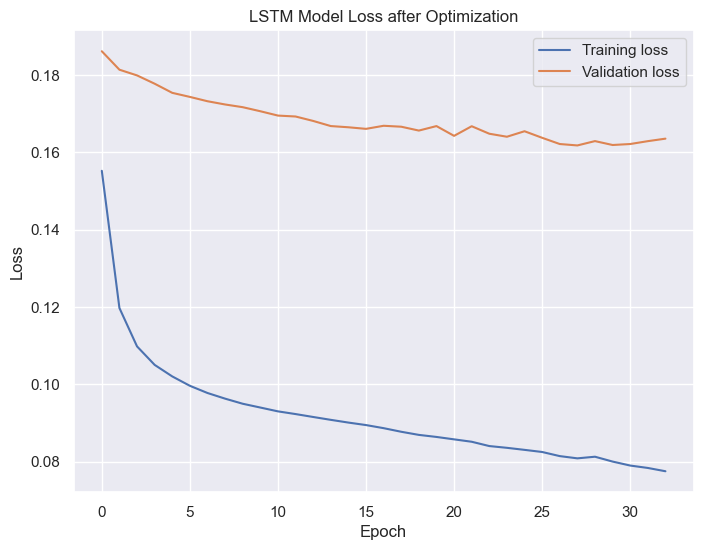

In [31]:
plt.figure(figsize=(8,6))
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.title('LSTM Model Loss after Optimization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
best_model.save('best_model_Multivariate_TS_LSTM.h5')

In [ ]:
# Load the model
# loaded_model = load_model('best_model_Multivariate_TS_LSTM.h5')

### Make Predictions

In [33]:
# Make predictions using the loaded model
# y_pred = loaded_model.predict(testX)

# Prediction on test samples
y_pred2 = best_model.predict(testX_scaled)
print(y_pred2.shape)   #   Predicted values (n_samples, n_future, n_features)

76/76 [==============================] - 13s 153ms/step
(2407, 144, 8)


In [36]:
# Inverse scaling the predictions

inverse_scaled_y_pred2 = inverse_scale_3d_series(y_pred2, testX_scalers, sub_df.columns)
print(inverse_scaled_y_pred2.shape)

inverse_scaled_y_true2 = inverse_scale_3d_series(testY_scaled, testY_scalers, sub_df.columns)
print(inverse_scaled_y_pred2.shape)


(2407, 144, 8)
(2407, 144, 8)


In [43]:
metrics2 = evaluate_model(sub_df.columns, inverse_scaled_y_true2, inverse_scaled_y_pred2)
# Print metrics for each feature
for feature, vals in metrics2.items():
    print(f"{feature}: {vals}")

Appliances: {'MAE': 51.93606829759911, 'MSE': 8890.638426781656, 'RMSE': 94.29018202751364, 'MAPE': 0.5397159688899913}
lights: {'MAE': 3.6476669007092775, 'MSE': 34.796927464319914, 'RMSE': 5.898892053964025, 'MAPE': 8799473602888937.0}
T_out: {'MAE': 3.2287546748668454, 'MSE': 16.402714985851958, 'RMSE': 4.050026541376236, 'MAPE': 0.26039525908914757}
RH_out: {'MAE': 13.448627286465147, 'MSE': 259.6663698343032, 'RMSE': 16.11416674340635, 'MAPE': 0.19536246045443353}
Press_mm_hg: {'MAE': 3.131875761509592, 'MSE': 16.35319293178041, 'RMSE': 4.043908126031106, 'MAPE': 0.004167220270237489}
Windspeed: {'MAE': 1.3735552193201523, 'MSE': 3.008997488813459, 'RMSE': 1.7346462143081105, 'MAPE': 4218712449216.333}
Visibility: {'MAE': 7.822180371827265, 'MSE': 107.28283645137401, 'RMSE': 10.357742826087835, 'MAPE': 0.36467144372719135}
Tdewpoint: {'MAE': 2.9327140662527778, 'MSE': 12.332419881180371, 'RMSE': 3.511754530313924, 'MAPE': 0.47677163393737004}


In [44]:
pd.DataFrame.from_dict(metrics2, orient='index').T

Appliances        lights      T_out      RH_out  Press_mm_hg  \
MAE     51.936068  3.647667e+00   3.228755   13.448627     3.131876   
MSE   8890.638427  3.479693e+01  16.402715  259.666370    16.353193   
RMSE    94.290182  5.898892e+00   4.050027   16.114167     4.043908   
MAPE     0.539716  8.799474e+15   0.260395    0.195362     0.004167   

         Windspeed  Visibility  Tdewpoint  
MAE   1.373555e+00    7.822180   2.932714  
MSE   3.008997e+00  107.282836  12.332420  
RMSE  1.734646e+00   10.357743   3.511755  
MAPE  4.218712e+12    0.364671   0.476772

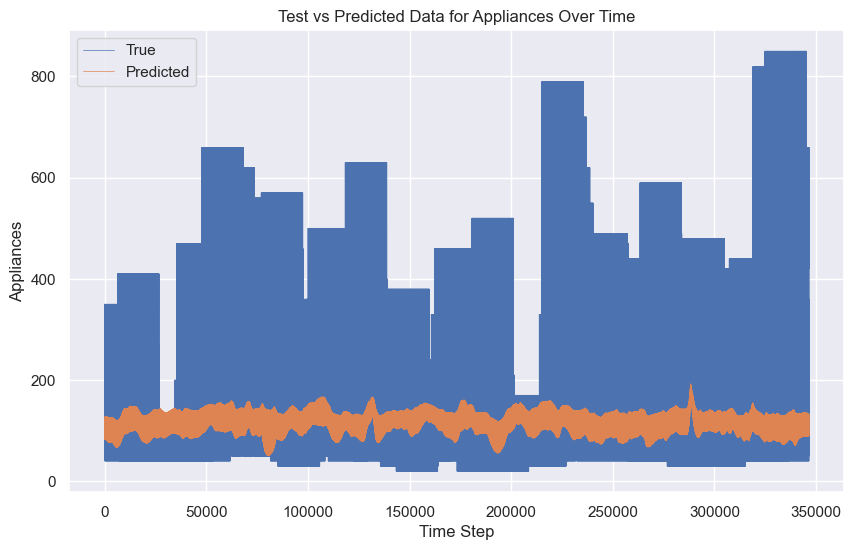

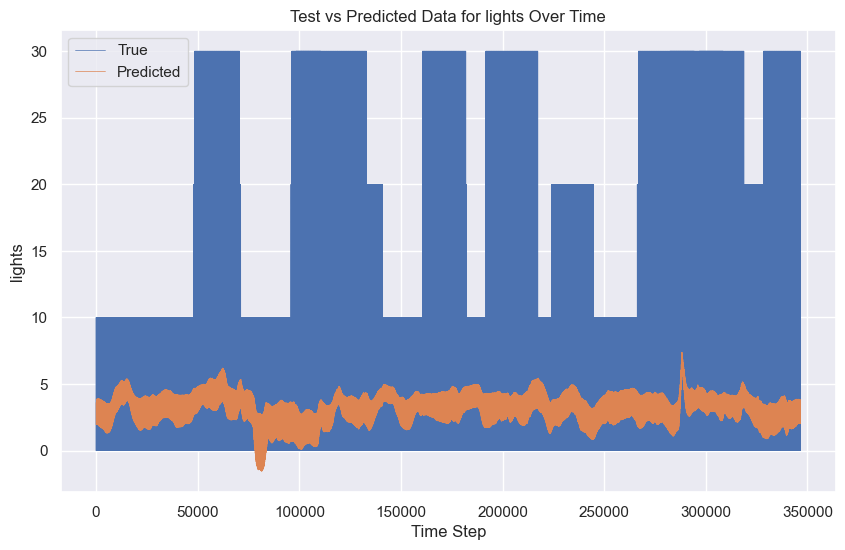

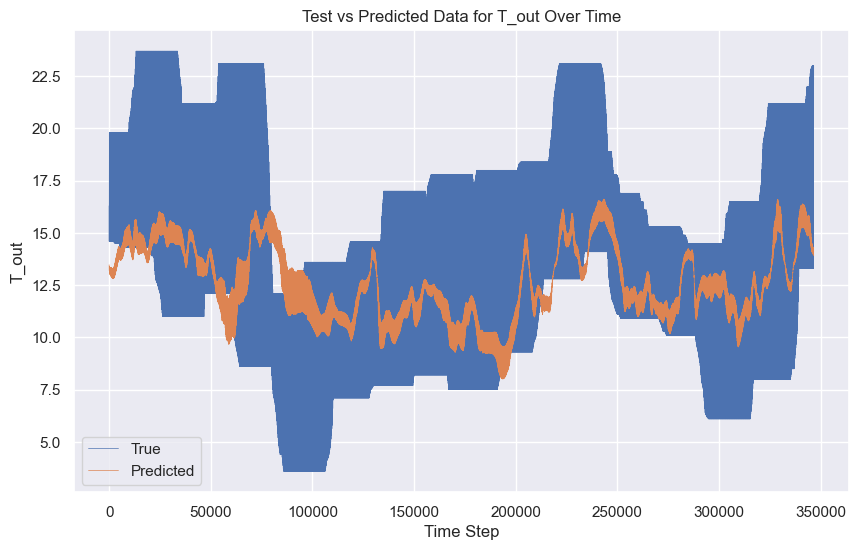

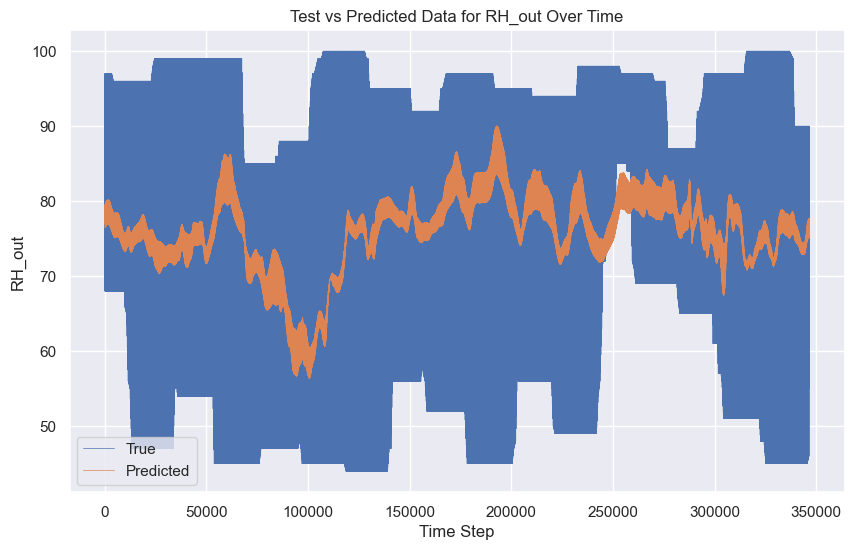

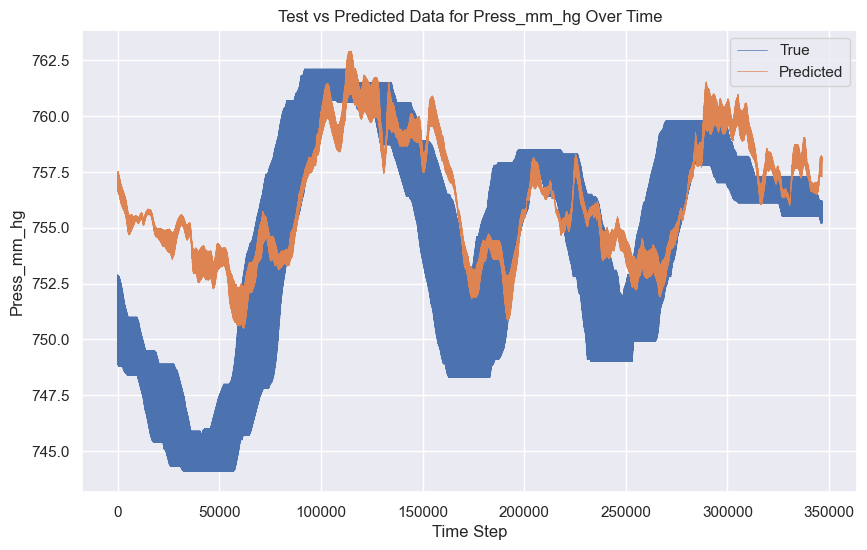

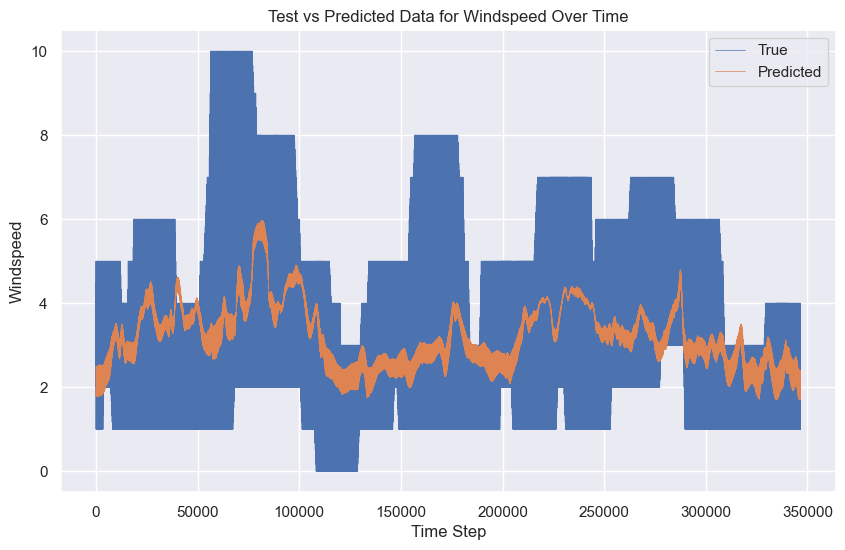

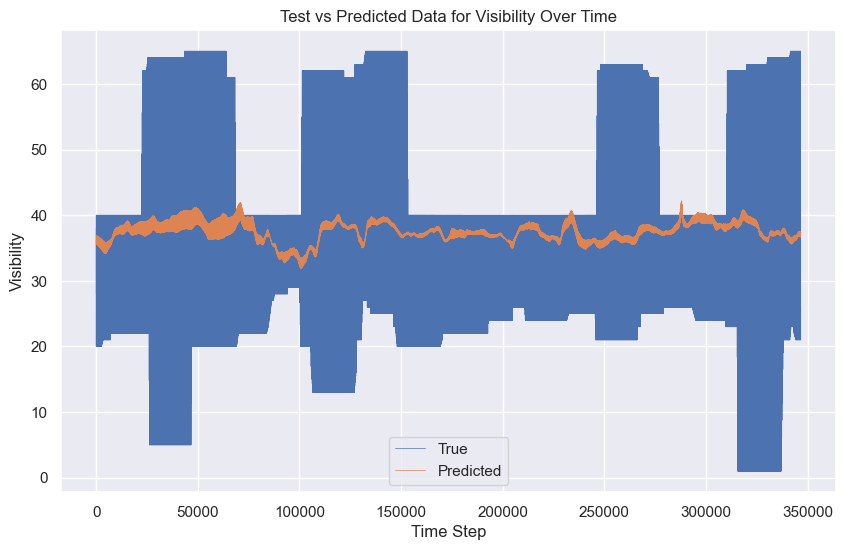

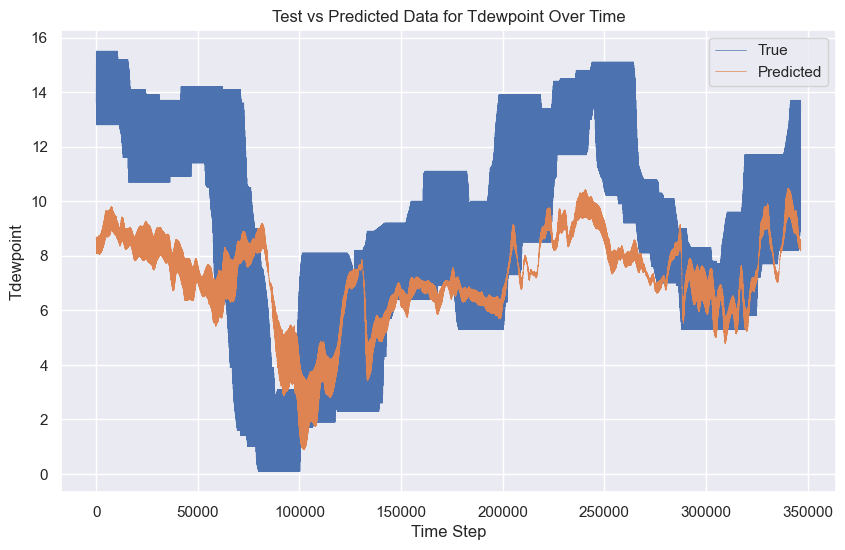

In [45]:
plot_3d_series(inverse_scaled_y_true2, inverse_scaled_y_pred2, feature_names=sub_df.columns)

### Reference:



    https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/
    https://www.kaggle.com/code/nicapotato/keras-timeseries-multi-step-multi-output
    https://www.kaggle.com/code/nikitricky/multivariate-multi-step-time-series-forecasting
    https://www.kaggle.com/code/lokeshkumarn/timeseries-multivariate
    https://www.kaggle.com/code/mineshjethva/time-series-forecasting-with-lstm-for-uni-multivar
    https://www.geeksforgeeks.org/multivariate-time-series-forecasting-with-lstms-in-keras/
    
    
    https://medium.com/@pierre.beaujuge/multivariate-time-series-forecasting-with-a-bidirectional-lstm-building-a-model-geared-to-4f020a160636
    
    https://www.kaggle.com/code/preatcher/multivariate-lstm
    https://www.kaggle.com/code/bagavathypriya/multivariate-time-series-analysis-using-lstm
    https://www.kaggle.com/code/dhamvi01/multivariate-time-series-using-lstm
    
    https://vannguyen-8073.medium.com/using-lstm-multivariate-and-univariate-in-order-to-predict-stock-market-39e8f6551c93
    https://github.com/vannguyen3007/LSTM-Multivariate-vs-Univariate/blob/main/Use_LSTM_to_prediction.ipynb
    
    
    https://tracyrenee61.medium.com/youtube-video-review-multivariate-time-series-forecasting-using-lstm-by-digitalsreeni-e4a2b330931d
    
    https://medium.com/@786sksujanislam786/multivariate-time-series-forecasting-using-lstm-4f8a9d32a509
    https://pangkh98.medium.com/multi-step-multivariate-time-series-forecasting-using-lstm-92c6d22cd9c2
    https://medium.com/@soubhikkhankary28/multivariate-time-series-forecasting-using-rnn-lstm-8d840f3f9aa7
    https://github.com/bnsreenu/python_for_microscopists/blob/master/181_multivariate_timeseries_LSTM_GE.py#L91
    
    
    https://medium.com/@seelcs12/multivariate-timeseries-forecasting-for-air-quality-prediction-f5bc772bc8a6
    https://forecastegy.com/posts/multiple-time-series-forecasting-with-lstm-in-python/
    